In [1]:
import json
import re
import csv
import time
import random
import glob
import tqdm
import copy
import math
import pandas as pd
import numpy as np
import itertools
import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torch.nn import Module
from torch.nn import MSELoss
from torch.nn import BCELoss,BCEWithLogitsLoss
from torch.nn import init
from torch.nn.functional import normalize
from torch.optim import Adam,Adadelta,RMSprop

from dgl.nn.pytorch import GATConv

from scipy.sparse import coo_matrix
from scipy.sparse import vstack
from scipy import sparse
from math import exp
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

# random.seed(0)
# np.random.seed(0)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
torch.cuda._initialized = True

#from src.Dataset import ACM_Dataset,Amazon_Dataset,Movielens_Dataset
from src.models import MF,NeuMF,GCF
from src.Utils import BPRLoss,Wrap_Dataset,EarlyStopping
#from src.Evaluate import evaluate

True
0


In [ ]:
lambda x: sum([ math.log(2) / math.log(1 + i) for i in range(1,x+1)]) if x<=top_k else sum([ math.log(2) / math.log(1 + i) for i in range(1,6)])

In [2]:
def call_hit_ratio(df_eval,df_static,top_k):
    top_k = df_eval[df_eval['rank']<=top_k]
    truth_in_top_k  = top_k[top_k['rating']==1]
    return len(truth_in_top_k) * 1.0 / (df_static['len'].sum())

def jud(x):
    #print(x)
    if x<=5:
        return sum([ math.log(2) / math.log(1 + i) for i in range(1,x+1)])
    else:
        return sum([ math.log(2) / math.log(1 + i) for i in range(1,6)])

def call_ndcg(df_eval,df_static,top_k):
    top_k = df_eval[df_eval['rank']<=top_k]
    truth_in_top_k  = top_k[top_k['rating']==1]
    full = pd.merge(truth_in_top_k, df_static, on=['uid'],how='left')
    #print(full['len'].max(),full['len'].min())
    full['dcg'] = full['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1
    full['idcg'] = full['len'].apply(lambda x: jud(x)) 
    full['ndcg'] = full.apply(lambda row:row['dcg']/row['idcg'],axis=1)
    #return truth_in_top_k['ndcg'].sum() * 1.0 / (df_eval['uid'].nunique()*sum([ math.log(2) / math.log(1 + i) for i in range(1,6)]))
    return full['ndcg'].sum() * 1.0 / df_eval['uid'].nunique()

def evaluate(evaluate_data,input_data, model,loss_func,top_k,use_cuda=True):
    """
    input_data --> 计算验证损失
    evaluate_data --> 计算指标
    
    """
    model.eval()
    with torch.no_grad():
        if use_cuda:
            eval_user = torch.LongTensor(evaluate_data['uid']).cuda()
            eval_item = torch.LongTensor(evaluate_data['iid']).cuda()
            eval_rating = torch.FloatTensor(evaluate_data['rating']).cuda()
            
            eval_user_input = torch.LongTensor(input_data['uid']).cuda()
            eval_pos = torch.LongTensor(input_data['pos_iid']).cuda()
            eval_neg = torch.LongTensor(input_data['neg_iid']).cuda()
        else:
            eval_user = torch.LongTensor(evaluate_data['uid']).cpu()
            eval_item = torch.LongTensor(evaluate_data['iid']).cpu()
            eval_rating = torch.FloatTensor(evaluate_data['rating']).cpu()
            
            eval_user_input = torch.LongTensor(input_data['uid']).cpu()
            eval_pos = torch.LongTensor(input_data['pos_iid']).cpu()
            eval_neg = torch.LongTensor(input_data['neg_iid']).cpu()
            
        #print(eval_user.shape,eval_item.shape)    
        scores = model(eval_user, eval_item)
        val_loss = loss_func(eval_user_input,eval_pos,eval_neg)
            
            
        #把数据转存到cpu,从而使用pandas
        eval_user = torch.LongTensor(evaluate_data['uid']).cpu()
        eval_item = torch.LongTensor(evaluate_data['iid']).cpu()
        eval_rating = torch.FloatTensor(evaluate_data['rating']).cpu()
        scores = scores.cpu()
        
        df_eval = pd.DataFrame([], columns=['uid', 'iid','rating', 'score'])
        df_eval['uid'] = eval_user.data.view(-1).tolist()
        df_eval['iid'] = eval_item.data.view(-1).tolist()
        df_eval['rating'] = eval_rating.data.view(-1).tolist()
        df_eval['score'] = scores.data.view(-1).tolist()
        
        df_eval['rank'] = df_eval.groupby('uid')['score'].rank(method='first', ascending=False)
        
        df_static = df_eval[df_eval['rating']==1].groupby('uid')['iid'].apply(set).reset_index().rename(columns={'iid': 'interacted_items'})
        df_static['len'] = df_static['interacted_items'].apply(lambda x:len(x))
        df_static.sort_values(by='uid', inplace=True)
        df_eval.sort_values(['uid', 'rank'], inplace=True)
        
        return val_loss.item(),call_hit_ratio(df_eval,df_static,top_k),call_ndcg(df_eval,df_static,top_k)

In [3]:
def call_hit_ratio2(df_eval,df_static,top_k):
    top_k = df_eval[df_eval['rank']<=top_k]
    truth_in_top_k  = top_k[top_k['rating']==1]
    full = pd.merge(truth_in_top_k, df_static, on=['uid'],how='left')
    stat = full[['uid','len','rating']].groupby('uid')['rating'].apply(sum).reset_index().rename(columns={'rating': 'recall_num'})
    stat2 = pd.merge(stat, df_static, on=['uid'],how='left')
    stat2['hr_perU'] = stat2.apply(lambda row:row['recall_num']/row['len'],axis=1)
    #stat['hr'] = stat.apply(lambda row:row['recall_num']/row['len'],axis=1)
    return stat2[['uid','len','recall_num','hr_perU']]

def jud(x):
    #print(x)
    if x<=5:
        return sum([ math.log(2) / math.log(1 + i) for i in range(1,x+1)])
    else:
        return sum([ math.log(2) / math.log(1 + i) for i in range(1,6)])

def call_ndcg2(df_eval,df_static,top_k):
    top_k = df_eval[df_eval['rank']<=top_k]
    truth_in_top_k  = top_k[top_k['rating']==1]
    full = pd.merge(truth_in_top_k, df_static, on=['uid'],how='left')
    #print(full['len'].max(),full['len'].min())
    full['dcg'] = full['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1
    full['idcg'] = full['len'].apply(lambda x: jud(x)) 
    full['ndcg'] = full.apply(lambda row:row['dcg']/row['idcg'],axis=1)
    
    stat = full[['uid','len','ndcg']].groupby('uid')['ndcg'].apply(sum).reset_index().rename(columns={'ndcg': 'ndcg_perU'})
    stat2 = pd.merge(stat, df_static, on=['uid'],how='left')
    #return truth_in_top_k['ndcg'].sum() * 1.0 / (df_eval['uid'].nunique()*sum([ math.log(2) / math.log(1 + i) for i in range(1,6)]))
    return stat2[['uid','len','ndcg_perU']]

def evaluate2(evaluate_data,input_data, model,loss_func,top_k,use_cuda=True):
    """
    input_data --> 计算验证损失
    evaluate_data --> 计算指标
    
    """
    model.eval()
    with torch.no_grad():
        if use_cuda:
            eval_user = torch.LongTensor(evaluate_data['uid']).cuda()
            eval_item = torch.LongTensor(evaluate_data['iid']).cuda()
            eval_rating = torch.FloatTensor(evaluate_data['rating']).cuda()
            
            eval_user_input = torch.LongTensor(input_data['uid']).cuda()
            eval_pos = torch.LongTensor(input_data['pos_iid']).cuda()
            eval_neg = torch.LongTensor(input_data['neg_iid']).cuda()
        else:
            eval_user = torch.LongTensor(evaluate_data['uid']).cpu()
            eval_item = torch.LongTensor(evaluate_data['iid']).cpu()
            eval_rating = torch.FloatTensor(evaluate_data['rating']).cpu()
            
            eval_user_input = torch.LongTensor(input_data['uid']).cpu()
            eval_pos = torch.LongTensor(input_data['pos_iid']).cpu()
            eval_neg = torch.LongTensor(input_data['neg_iid']).cpu()
            
        #print(eval_user.shape,eval_item.shape)    
        scores = model(eval_user, eval_item)
        val_loss = loss_func(eval_user_input,eval_pos,eval_neg)
            
            
        #把数据转存到cpu,从而使用pandas
        eval_user = torch.LongTensor(evaluate_data['uid']).cpu()
        eval_item = torch.LongTensor(evaluate_data['iid']).cpu()
        eval_rating = torch.FloatTensor(evaluate_data['rating']).cpu()
        scores = scores.cpu()
        
        df_eval = pd.DataFrame([], columns=['uid', 'iid','rating', 'score'])
        df_eval['uid'] = eval_user.data.view(-1).tolist()
        df_eval['iid'] = eval_item.data.view(-1).tolist()
        df_eval['rating'] = eval_rating.data.view(-1).tolist()
        df_eval['score'] = scores.data.view(-1).tolist()
        
        df_eval['rank'] = df_eval.groupby('uid')['score'].rank(method='first', ascending=False)
        
        df_static = df_eval[df_eval['rating']==1].groupby('uid')['iid'].apply(set).reset_index().rename(columns={'iid': 'interacted_items'})
        df_static['len'] = df_static['interacted_items'].apply(lambda x:len(x))
        df_static.sort_values(by='uid', inplace=True)
        df_eval.sort_values(['uid', 'rank'], inplace=True)
        
        return val_loss.item(),call_hit_ratio2(df_eval,df_static,top_k),call_ndcg2(df_eval,df_static,top_k)

In [90]:
df_at = pd.read_csv('ACM/a2p.csv')
interact_status = df_at.groupby('aid')['pid'].apply(set).reset_index().rename(columns={'pid': 'interacted_items'})
interact_status['len'] = interact_status['interacted_items'].apply(lambda x:len(x))

In [56]:
interact_status[interact_status['len']<=1],interact_status[interact_status['len']<=2],interact_status[interact_status['len']<=3],interact_status[interact_status['len']<=5],
#interact_status[(interact_status['len']>5) & (interact_status['len']<=10)],interact_status[interact_status['len']>10]

(         aid interacted_items  len
 0          0           {5521}    1
 4          4            {893}    1
 5          5           {5782}    1
 11        11           {3817}    1
 12        12           {1523}    1
 ...      ...              ...  ...
 18374  18374           {6361}    1
 18382  18382          {10602}    1
 18383  18383            {614}    1
 18384  18384           {2520}    1
 18386  18386           {3539}    1
 
 [5586 rows x 3 columns],          aid interacted_items  len
 0          0           {5521}    1
 4          4            {893}    1
 5          5           {5782}    1
 7          7     {6297, 9615}    2
 10        10     {8098, 2292}    2
 ...      ...              ...  ...
 18382  18382          {10602}    1
 18383  18383            {614}    1
 18384  18384           {2520}    1
 18386  18386           {3539}    1
 18387  18387      {798, 9951}    2
 
 [8450 rows x 3 columns],          aid   interacted_items  len
 0          0             {5521}    1
 4    

In [4]:
class ACM_Dataset(object):
    def __init__(self,config_dat):
        self.dataset_name = config_dat['dataset_name']
        #self.model_name = model_name
        self.Load_flag = config_dat['isLoad']
        self.Store_flag =config_dat['store']
        self.filepaths = config_dat['filepaths']
        self.uNum,self.iNum = self.ACM_get_nums()
        self.train,self.dev,self.test = self.data_split(config_dat['neg_num4train'])
        #self.train = self.train.append([self.uNum-1,self.iNum-1,None])
        self.train['rating'] = [1 for i in range(len(self.train))]
        self.input_train = self.ACM_build_input_data(1)
        self.input_dev = self.ACM_build_input_data(2)
        self.input_test = self.ACM_build_input_data(3)
        self.eval_dev,self.eval_test = self.ACM_build_eval_data()
        
        self.a2a,self.p2p = self.ACM_relation_process()
        self.mp_graphs = self.ACM_create_mp_neighbor_graph()
        
        L_u2i,L_u2i_hat = self.ACM_buildLaplacianMat_u2i()
        L_u2u,L_u2u_hat = self.ACM_buildLaplacianMat_u2u()
        L_i2i,L_i2i_hat = self.ACM_buildLaplacianMat_i2i()
        self.u2i = [(L_u2i,L_u2i_hat),[self.uNum,self.iNum]]
        self.u2es = [[(L_u2u,L_u2u_hat,None),0,True]]
        self.i2es = [[(L_i2i,L_i2i_hat,None),0,True]]
        
        self.full,self.full_hat = self.ACM_buildLaplacianMat_full()
        self.num_list = [self.uNum,self.iNum]
        
    def ACM_get_nums(self):
        df_a2p = pd.read_csv(self.filepaths[1])
        return df_a2p['aid'].max()+1,df_a2p['pid'].max()+1
    
    def ACM_split(self,df_u2i):
        """ 
        interact>20 ---> [n-20:10:10]
        20>=interact>10 ---> [n-10:0:10]
        10>=interact ---> [n:0:0]
        
        """
        rd_val = []
        for i in range(len(df_u2i)):
            rd_val.append(random.random())
        df_u2i['random_val']=rd_val
        df_u2i['rank'] = df_u2i.groupby(['aid'])['random_val'].rank(method='first', ascending=False)

        grouped = df_u2i.groupby(['aid'])
        test1 = pd.DataFrame([], columns=['aid', 'pid','negatives'])
        dev1 = pd.DataFrame([], columns=['aid', 'pid','negatives'])
        train1 = pd.DataFrame([], columns=['aid', 'pid','negatives'])
        for name,group in tqdm.tqdm(grouped):
            split_list = np.array_split(list(range(1,len(group)+1)),3)
            train1 = train1.append(group[group['rank'].isin(split_list[0])])
            test1 = test1.append(group[group['rank'].isin(split_list[1])])
            dev1 = dev1.append(group[group['rank'].isin(split_list[2])])
            
        return train1[['aid', 'pid','negatives']],dev1[['aid', 'pid','negatives']], test1[['aid', 'pid','negatives']]
    
    def get_prob(self,neg_items,counter_dict):
        """ get the prob of each neg_items"""
        neg_occurance = [counter_dict[i] for i in neg_items] 
        neg_num = sum(neg_occurance)
        neg_prob = [i/neg_num for i in neg_occurance]
        return neg_prob
    
    def negative_sample(self,row_item,row_prob,row_len,neg_ratio,max_num):
        if row_len * neg_ratio> max_num:
            return np.random.choice(list(row_item),row_len,replace=False,
                                                                  p = row_prob)
        else:
            return np.random.choice(list(row_item),neg_ratio*row_len,replace=False,
                                                                  p = row_prob)
        
    def ACM_get_negative_items(self,df_u2i,neg_ratio):
        paper_pool = set(df_u2i['pid'].unique())
        #max_num = len(paper_pool)
        counter_dict = Counter(df_u2i['pid'])
        interact_status = df_u2i.groupby('aid')['pid'].apply(set).reset_index().rename(columns={'pid': 'interacted_items'})
        interact_status['len'] = interact_status['interacted_items'].apply(lambda x:len(x))
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: paper_pool - x)
        interact_status['negative_probs'] = interact_status['negative_items'].apply(lambda x:self.get_prob(x,counter_dict))
        interact_status['len_neg'] = interact_status['negative_items'].apply(lambda x:len(x))
        interact_status['negatives'] = interact_status.apply(lambda row:self.negative_sample(row['negative_items'],
                                                                                            row['negative_probs'],
                                                                                            row['len'],
                                                                                            neg_ratio,
                                                                                            row['len_neg']),axis=1)
        return interact_status[['aid','interacted_items','negatives','len']]
    
    def ACM_negative_allocation(self,neg):
        neg['pids'] = neg['interacted_items'].apply(list)
        neg['split_negtives'] = neg.apply(lambda row: list(np.array_split(row['negatives'], row['len'])),axis=1)
        uids,iids,neg_items = [],[],[]
        for row in neg.itertuples():
            for i,n in zip(row.pids,row.split_negtives):
                uids.append(row.aid)
                iids.append(i)
                neg_items.append(n)
        full = pd.DataFrame()
        full['aid']=uids
        full['pid']=iids
        full['negatives']=neg_items

        return full[['aid','pid','negatives']] 
    
    def ACM_split_and_sample(self, neg_ratio):
        df_u2i = pd.read_csv(self.filepaths[1]) 
        
        neg = self.ACM_get_negative_items(df_u2i,neg_ratio)
        full = self.ACM_negative_allocation(neg)
        train,dev,test = self.ACM_split(full)
        if self.Store_flag:
            train.to_csv(self.filepaths[0]+'train.csv')
            dev.to_csv(self.filepaths[0]+'dev.csv')
            test.to_csv(self.filepaths[0]+'test.csv')
        return train,dev,test
    
    def data_split(self, neg_ratio):
        if self.Load_flag==True:
            #raise Exception("Dataset has been loaded.")
            train = pd.read_csv(self.filepaths[0]+'train.csv')
            dev = pd.read_csv(self.filepaths[0]+'dev.csv')
            test = pd.read_csv(self.filepaths[0]+'test.csv')
        else:
            train,dev,test = self.ACM_split_and_sample(neg_ratio)
        print('Dataset has been splited!')
        return train,dev,test
    ###############################################################################################################################
    def ACM_build_input_data(self,dat_type):
        authors, pos_papers, neg_papers = [], [], []
        input_dat= pd.DataFrame()
        
        if self.Load_flag==True:
            if dat_type==1:
                for row in self.train.itertuples():
                    for i in row.negatives[1:-2].split():
                        authors.append(int(row.aid))
                        pos_papers.append(int(row.pid))
                        neg_papers.append(int(i))
            if dat_type==2:
                for row in self.dev.itertuples():
                    for i in row.negatives[1:-2].split():
                        authors.append(int(row.aid))
                        pos_papers.append(int(row.pid))
                        neg_papers.append(int(i))
            if dat_type==3:
                for row in self.test.itertuples():
                    for i in row.negatives[1:-2].split():
                        authors.append(int(row.aid))
                        pos_papers.append(int(row.pid))
                        neg_papers.append(int(i))
        else:
            if dat_type==1:
                for row in self.train.itertuples():
                    for i in row.negatives:
                        authors.append(int(row.aid))
                        pos_papers.append(int(row.pid))
                        neg_papers.append(int(i))
            if dat_type==2:
                for row in self.dev.itertuples():
                    for i in row.negatives:
                        authors.append(int(row.aid))
                        pos_papers.append(int(row.pid))
                        neg_papers.append(int(i))
            if dat_type==3:
                for row in self.test.itertuples():
                    for i in row.negatives:
                        authors.append(int(row.aid))
                        pos_papers.append(int(row.pid))
                        neg_papers.append(int(i))
                        
        input_dat['uid']=authors
        input_dat['pos_iid']=pos_papers
        input_dat['neg_iid']=neg_papers
        return input_dat
    
    def ACM_build_eval_data(self):
        authors,papers,ratings = [],[],[]
        eval_dev=pd.DataFrame()
        if self.Load_flag==True:
            for row in self.dev.itertuples():
                for i in row.negatives[1:-2].split():
                    authors.append(int(row.aid))
                    papers.append(int(i))
                    ratings.append(float(0))  # negative samples get 0 rating
                authors.append(int(row.aid))
                papers.append(int(row.pid))
                ratings.append(float(1))
        else:
            for row in self.dev.itertuples():
                for i in row.negatives:
                    authors.append(int(row.aid))
                    papers.append(int(i))
                    ratings.append(float(0))  # negative samples get 0 rating
                authors.append(int(row.aid))
                papers.append(int(row.pid))
                ratings.append(float(1))
        eval_dev['uid']=authors
        eval_dev['iid']=papers
        eval_dev['rating']=ratings
        
        authors,papers,ratings = [],[],[]
        eval_test=pd.DataFrame()
        if self.Load_flag==True:
            for row in self.test.itertuples():
                for i in row.negatives[1:-2].split():
                    authors.append(int(row.aid))
                    papers.append(int(i))
                    ratings.append(float(0))  # negative samples get 0 rating
                authors.append(int(row.aid))
                papers.append(int(row.pid))
                ratings.append(float(1))
        else:
            for row in self.test.itertuples():
                for i in row.negatives:
                    authors.append(int(row.aid))
                    papers.append(int(i))
                    ratings.append(float(0))  # negative samples get 0 rating
                authors.append(int(row.aid))
                papers.append(int(row.pid))
                ratings.append(float(1))
        eval_test['uid']=authors
        eval_test['iid']=papers
        eval_test['rating']=ratings
        
        return eval_dev,eval_test
    ###############################################################################################################################
    
    def ACM_relation_process(self):
        """
        load relation data
        if relation is self interaction ---> drop self link
        
        """
        # load data
        df_a2a = pd.read_csv(self.filepaths[0]+'a2a.csv')
        df_p2p = pd.read_csv(self.filepaths[0]+'p2p.csv')
        
        # self link drop
        df_a2a = df_a2a[df_a2a['aid']!=df_a2a['aid_2']]
        df_p2p = df_p2p[df_p2p['pid']!=df_p2p['pid_2']]
        
        # add link flag
        df_a2a['link']=[1 for i in range(len(df_a2a))]
        df_p2p['link']=[1 for i in range(len(df_p2p))]
        return df_a2a,df_p2p
    
    ###############################################################################################################################
    def ACM_sample_mp_neighbor(self,df):
        sample_df = pd.DataFrame([],columns = ['aid','pid'])
        grouped_df = df.groupby('aid')
        for name,group in tqdm.tqdm(grouped_df):
            if len(group)> 100:
                    sample_df = sample_df.append(group.sample(n=100, replace=False))
            if 100>=len(group)>10:
                    sample_df = sample_df.append(group.sample(frac=0.1, replace=False))
            if len(group)<=10:
                    sample_df = sample_df.append(group)
        return sample_df
                    
    def ACM_create_mp_neighbor_graph(self):
        """
        creat metapath neighbor: APP, AAP
        and transform to DGL Graph
        """
        
        if self.Load_flag==True:
            df_app = pd.read_csv(self.filepaths[0]+'app.csv')
            df_aap = pd.read_csv(self.filepaths[0]+'aap.csv')
        else:
            df_app = pd.merge(self.train, self.p2p, on=['pid'])
            
            df_aap = pd.merge(self.a2a, self.train, on=['aid'])

            df_aap = df_aap[['aid','pid']].drop_duplicates().reset_index(drop=True)
            df_app = df_app[['aid','pid']].drop_duplicates().reset_index(drop=True)

            #sample (sample standard? sample strategy?)
            
            if len(df_app)>200000:
                print('length of app:',len(df_app),'start sampling...') 
                df_app = self.ACM_sample_mp_neighbor(df_app)

            if len(df_aap)>200000:
                print('length of aap:',len(df_aap),'start sampling...') 
                df_aap = self.ACM_sample_mp_neighbor(df_aap)
                
            if self.Store_flag==True:
                df_app.to_csv('ACM/app.csv')
                df_aap.to_csv('ACM/aap.csv')

        df_app['n_pid'] = df_app['pid'].apply(lambda x: x+self.uNum)        
        df_aap['n_pid'] = df_aap['pid'].apply(lambda x: x+self.uNum)
        self.train['n_pid'] = self.train['pid'].apply(lambda x: x+self.uNum)
        
        g_ap = dgl.DGLGraph()
        g_ap.add_nodes(self.uNum+self.iNum)
        g_ap.add_edges(self.train['aid'].tolist(),self.train['n_pid'].tolist())
        g_ap.add_edges(self.train['n_pid'].tolist(),self.train['aid'].tolist())

        g_app = dgl.DGLGraph()
        g_app.add_nodes(self.uNum+self.iNum)
        g_app.add_edges(df_app['aid'].tolist(),df_app['n_pid'].tolist())
        g_app.add_edges(df_app['n_pid'].tolist(),df_app['aid'].tolist())

        g_aap = dgl.DGLGraph()
        g_aap.add_nodes(self.uNum+self.iNum)
        g_aap.add_edges(df_aap['aid'].tolist(),df_aap['n_pid'].tolist())
        g_aap.add_edges(df_aap['n_pid'].tolist(),df_aap['aid'].tolist())
        
        return [g_ap,g_app,g_aap]
    
    ###############################################################################################################################
    def getSparseEye(self,num):
        i = torch.LongTensor([[k for k in range(0,num)],[j for j in range(0,num)]])
        val = torch.FloatTensor([1]*num)
        return torch.sparse.FloatTensor(i,val)
    
    
    def ACM_buildLaplacianMat_u2i(self):

        rt_item = self.train['pid'] + self.uNum
        uiMat = coo_matrix((self.train['rating'], (self.train['aid'], self.train['pid'])))

        uiMat_upperPart = coo_matrix((self.train['rating'], (self.train['aid'], rt_item)))
        uiMat = uiMat.transpose()
        uiMat.resize((self.iNum, self.uNum + self.iNum))
        uiMat_upperPart.resize((self.uNum, self.uNum + self.iNum))
        
        #print(self.uNum + self.iNum,uiMat_upperPart.shape,uiMat.shape)

        A = sparse.vstack([uiMat_upperPart,uiMat])
        selfLoop = sparse.eye(self.uNum+self.iNum)
        sumArr = (A>0).sum(axis=1)
        diag = list(np.array(sumArr.flatten())[0])
        diag = np.power(diag,-0.5)
        diag[np.isinf(diag)] = 0
        D = sparse.diags(diag)
        L = D * A * D
        L = sparse.coo_matrix(L)
        row = L.row
        col = L.col
        data = L.data
        
        # item的最后一号恰好没有交互，所以这里要补全
        row = np.append(row,self.uNum + self.iNum-1)
        col = np.append(col,self.uNum + self.iNum-1)
        data = np.append(data,0)
        
        i = torch.LongTensor([row,col])
        data = torch.FloatTensor(data)
        SparseL = torch.sparse.FloatTensor(i,data)
        SL = self.getSparseEye(self.uNum+self.iNum)
        
        return SparseL, SparseL+SL
    
    def ACM_buildLaplacianMat_u2u(self):
        uuMat = coo_matrix((self.a2a['link'], (self.a2a['aid'], self.a2a['aid_2'])))

        # item的最后一号恰好没有交互，所以这里要补全
        #iiMat.resize((self.iNum, self.uNum + self.iNum))
        
        #uiMat_upperPart = coo_matrix((rt['rating'], (rt['aid'], rt_item)))
        #uiMat = uiMat.transpose()
        #uiMat.resize((self.itemNum, self.userNum + self.itemNum))
        
        A = uuMat
        selfLoop = sparse.eye(self.uNum)
        sumArr = (A>0).sum(axis=1)
        diag = list(np.array(sumArr.flatten())[0])
        diag = np.power(diag,-0.5)
        diag[np.isinf(diag)] = 0
        D = sparse.diags(diag)
        L = D * A * D
        L = sparse.coo_matrix(L)
        row = L.row
        col = L.col
        data = L.data
        
        # item的最后一号恰好没有交互，所以这里要补全
        #row = np.append(row,self.uNum + self.iNum-1)
        #col = np.append(col,self.uNum + self.iNum-1)
        #data = np.append(data,0)
        
        i = torch.LongTensor([row,col])
        data = torch.FloatTensor(data)
        SparseL = torch.sparse.FloatTensor(i,data)
        SL = self.getSparseEye(self.uNum)
        
        return SparseL, SparseL+SL
    
    
    def ACM_buildLaplacianMat_i2i(self):
        iiMat = coo_matrix((self.p2p['link'], (self.p2p['pid'], self.p2p['pid_2'])))

        # item的最后一号恰好没有交互，所以这里要补全
        iiMat.resize((self.iNum, self.iNum))
        
        #uiMat_upperPart = coo_matrix((rt['rating'], (rt['aid'], rt_item)))
        #uiMat = uiMat.transpose()
        #uiMat.resize((self.itemNum, self.userNum + self.itemNum))
        
        A = iiMat
        selfLoop = sparse.eye(self.iNum)
        sumArr = (A>0).sum(axis=1)
        diag = list(np.array(sumArr.flatten())[0])
        diag = np.power(diag,-0.5)
        diag[np.isinf(diag)] = 0
        D = sparse.diags(diag)
        L = D * A * D
        L = sparse.coo_matrix(L)
        row = L.row
        col = L.col
        data = L.data
        
        # item的最后一号恰好没有交互，所以这里要补全
        row = np.append(row,self.iNum-1)
        col = np.append(col,self.iNum-1)
        data = np.append(data,0)
        
        i = torch.LongTensor([row,col])
        data = torch.FloatTensor(data)
        SparseL = torch.sparse.FloatTensor(i,data)
        SL = self.getSparseEye(self.iNum)
        
        return SparseL, SparseL+SL
    
    def ACM_buildLaplacianMat_full(self):
        """  
        u - i 
        """
        uuMat = coo_matrix((self.a2a['link'], (self.a2a['aid'], self.a2a['aid_2'])))
        uuMat.resize((self.uNum,self.uNum))
        
        uiMat = coo_matrix((self.train['rating'], (self.train['aid'], self.train['pid'])))
        uiMat.resize((self.uNum,self.iNum))
        
        uMat = sparse.hstack([uuMat,uiMat])
        uMat.resize((self.uNum,self.uNum+self.iNum))

        ###################################################    
        iuMat = coo_matrix((self.train['rating'], (self.train['pid'], self.train['aid'])))
        iuMat.resize(self.iNum,self.uNum)
        
        iiMat = coo_matrix((self.p2p['link'], (self.p2p['pid'], self.p2p['pid_2'])))
        iiMat.resize(self.iNum,self.iNum)
        
        iMat = sparse.hstack([iuMat,iiMat])
        iMat.resize((self.iNum,self.uNum+self.iNum))
        
        full = sparse.vstack([uMat,iMat])
        A = full
        #selfLoop = sparse.eye(self.uNum+self.iNum+self.aNum+self.oNum+self.gNumm)
        sumArr = (A>0).sum(axis=1)
        diag = list(np.array(sumArr.flatten())[0])
        diag = np.power(diag,-0.5)
        diag[np.isinf(diag)] = 0
        D = sparse.diags(diag)
        L = D * A * D
        L = sparse.coo_matrix(L)

        row = L.row
        col = L.col
        data = L.data
        
        row = np.append(row,self.uNum + self.iNum-1)
        col = np.append(col,self.uNum + self.iNum-1)
        data = np.append(data,0)

        i = torch.LongTensor([row,col])
        data = torch.FloatTensor(data)
        SparseL = torch.sparse.FloatTensor(i,data)
        SL = self.getSparseEye(self.uNum+self.iNum)

        return SparseL, SparseL+SL

In [5]:
class RelationAttention(nn.Module):
    def __init__(self, in_size, hidden_size):
        super(RelationAttention, self).__init__()
        self.project = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False))

    def forward(self, z):
        w = self.project(z)
        beta = torch.softmax(w, dim=1)
        return (beta * z).sum(1)
    
    
class Message_Passing(Module):
    def __init__(self,inF,outF,useCuda):
        super(Message_Passing,self).__init__()
        self.inF = inF
        self.outF = outF
        self.useCuda = useCuda
        self.Transform = torch.nn.Linear(in_features=inF,out_features=outF)
        self.InterAct = torch.nn.Linear(in_features=inF,out_features=outF)

    def forward(self, L, L_hat,features):
        if self.useCuda:
            L=L.cuda()
            L_hat = L_hat.cuda()
        inter_part1 = torch.sparse.mm(L_hat,self.Transform(features))     
        inter_part2 = torch.sparse.mm(L,self.InterAct(torch.mul(features,features)))
        return inter_part1+inter_part2
    
    
class Message_Storage(Module):
    def __init__(self,useCuda):
        super(Message_Storage,self).__init__()
        self.useCuda = useCuda

    def forward(self, L_hat,features):
        if self.useCuda:
            L_hat = L_hat.cuda()
        return torch.sparse.mm(L_hat,features) 
    
    
class NHGCFLayer(Module):
    def __init__(self,inF,outF,proj_dim,useCuda,self_tag_u2es, self_tag_i2es):
        super(NHGCFLayer,self).__init__()
        self.inF = inF
        self.outF = outF
        self.useCuda = useCuda

        self.u2i_Cell = Message_Passing(inF,outF,useCuda)
        
        self.u2e_Cells = torch.nn.ModuleList()
        for i in self_tag_u2es:
            if i==True:
                self.u2e_Cells.append(Message_Passing(inF,outF,useCuda))
            else:
                self.u2e_Cells.append(torch.nn.ModuleList([Message_Passing(inF,outF,useCuda),Message_Storage(useCuda)]))
                
        self.i2e_Cells = torch.nn.ModuleList()
        for i in self_tag_i2es:
            if i==True:
                self.i2e_Cells.append(Message_Passing(inF,outF,useCuda))
            else:
                self.i2e_Cells.append(torch.nn.ModuleList([Message_Passing(inF,outF,useCuda),Message_Storage(useCuda)]))
         
        self.u_relation_attention = RelationAttention(in_size=self.inF,hidden_size=proj_dim)
        self.i_relation_attention = RelationAttention(in_size=self.inF,hidden_size=proj_dim)
        #self.relation_attention = RelationAttention(in_size=self.inF)
        
    def forward(self, u2i_pack, u2e_pack, i2e_pack, u_feature, i_feature, u2e_features, i2e_features):
        u_embeddings = []
        i_embeddings = []
        u2e_embeddings =[]
        i2e_embeddings =[]
        u_num = u2i_pack[1][0]
        #i_num = u2i_pack[2][1]
        
        for ((L_upper,L_upper_hat,L_down_hat),self_tag),u2e_feature,u2e_Cell in zip(u2e_pack,u2e_features,self.u2e_Cells):
            if self_tag is True:
                # self interact
                u_embeddings.append(u2e_Cell(L_upper,L_upper_hat,u_feature))
            else:
                u2e_embeddings.append(u2e_Cell[1](L_down_hat,torch.cat([u_feature,u2e_feature],dim=0)))
                u_embeddings.append(u2e_Cell[0](L_upper,L_upper_hat,torch.cat([u_feature,u2e_feature],dim=0)))
            
            
        for ((L_upper,L_upper_hat,L_down_hat),self_tag),i2e_feature,i2e_Cell in zip(i2e_pack,i2e_features,self.i2e_Cells):
            if self_tag is True:
                # self interact
                i_embeddings.append(i2e_Cell(L_upper,L_upper_hat,i_feature))
            else:
                i2e_embeddings.append(i2e_Cell[1](L_down_hat,torch.cat([i_feature,i2e_feature],dim=0)))
                i_embeddings.append(i2e_Cell[0](L_upper,L_upper_hat,torch.cat([i_feature,i2e_feature],dim=0)))
                
        temp = self.u2i_Cell(u2i_pack[0][0],u2i_pack[0][1],torch.cat([u_feature,i_feature],dim=0))
        i_embeddings.append(temp[u_num:]) 
        u_embeddings.append(temp[:u_num])
        
        i_embeddings = torch.stack(i_embeddings, dim=1)
        u_embeddings = torch.stack(u_embeddings, dim=1)
        return self.u_relation_attention(u_embeddings),self.i_relation_attention(i_embeddings),u2e_embeddings,i2e_embeddings
        #return self.relation_attention(u_embeddings),self.relation_attention(i_embeddings),u2e_embeddings,i2e_embeddings
    
    

class NHGCF(Module):
    def __init__(self,config,u2i,u2es,i2es):
        """
        u2es[x][0]: laplacian
        u2es[x][1]: node num
        u2es[x][2]: self intercat tag
        """
        super(NHGCF,self).__init__()
        self.useCuda = config['cuda']
        
        self.userNum = u2i[1][0]
        self.itemNum = u2i[1][1]
        self.proj_dim = config['proj_dim']
        
        self.uEmbd = nn.Embedding(self.userNum,config['embed_dim'])
        self.iEmbd = nn.Embedding(self.itemNum,config['embed_dim'])
        self.u2i_pack = (u2i[0],[self.userNum,self.itemNum])
        
        self.u2eEmbds=torch.nn.ModuleList()
        self.L_u2es = []
        self.self_tag_u2es = []
        self.u2eNums =[]
        for u2e in u2es:
            self.L_u2es.append(u2e[0])
            self.u2eNums.append(u2e[1])
            if u2e[2]==False:
                self.u2eEmbds.append(nn.Embedding(u2e[1],config['embed_dim']))
            else:
                self.u2eEmbds.append(None)
            self.self_tag_u2es.append(u2e[2])
        self.u2e_pack = zip(self.L_u2es,self.self_tag_u2es)
            
        self.i2eEmbds=torch.nn.ModuleList()
        self.L_i2es = []
        self.self_tag_i2es = []
        self.i2eNums =[]
        for i2e in i2es:
            self.L_i2es.append(i2e[0])
            self.i2eNums.append(i2e[1])
            if i2e[2]==False:
                self.i2eEmbds.append(nn.Embedding(i2e[1],config['embed_dim']))
            else:
                self.i2eEmbds.append(None)
            self.self_tag_i2es.append(i2e[2])
        self.i2e_pack = zip(self.L_i2es,self.self_tag_i2es)    
    
        self.layers = config['layers']
        self.NHGCFLayers = torch.nn.ModuleList()
        self.leakyRelu = nn.LeakyReLU()

        for From,To in zip(self.layers[:-1],self.layers[1:]):
            self.NHGCFLayers.append(NHGCFLayer(From, To,self.proj_dim, self.useCuda, self.self_tag_u2es, self.self_tag_i2es))  
    # 参数初始化
    def weight_init(self):
        wts= [self.uEmbd.weight,
            self.iEmbd.weight,
            self.NHGCFLayers[0].u2i_Cell.Transform.weight,
            self.NHGCFLayers[0].u2i_Cell.InterAct.weight,
            self.NHGCFLayers[0].u2e_Cells[0].Transform.weight,
            self.NHGCFLayers[0].u2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[0].i2e_Cells[0].Transform.weight,
            self.NHGCFLayers[0].i2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[0].u_relation_attention.project[0].weight,
            self.NHGCFLayers[0].u_relation_attention.project[2].weight,
            self.NHGCFLayers[0].i_relation_attention.project[0].weight,
            self.NHGCFLayers[0].i_relation_attention.project[2].weight,
              
            self.NHGCFLayers[1].u2i_Cell.Transform.weight,
            self.NHGCFLayers[1].u2i_Cell.InterAct.weight,
            self.NHGCFLayers[1].u2e_Cells[0].Transform.weight,
            self.NHGCFLayers[1].u2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[1].i2e_Cells[0].Transform.weight,
            self.NHGCFLayers[1].i2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[1].u_relation_attention.project[0].weight,
            self.NHGCFLayers[1].u_relation_attention.project[2].weight,
            self.NHGCFLayers[1].i_relation_attention.project[0].weight,
            self.NHGCFLayers[1].i_relation_attention.project[2].weight,
              
            #self.NHGCFLayers[2].u2i_Cell.Transform.weight,
            #self.NHGCFLayers[2].u2i_Cell.InterAct.weight,
            #self.NHGCFLayers[2].u2e_Cells[0].Transform.weight,
            #self.NHGCFLayers[2].u2e_Cells[0].InterAct.weight,
            #self.NHGCFLayers[2].i2e_Cells[0].Transform.weight,
            #self.NHGCFLayers[2].i2e_Cells[0].InterAct.weight,
            #self.NHGCFLayers[2].u_relation_attention.project[0].weight,
            #self.NHGCFLayers[2].u_relation_attention.project[2].weight,
            #self.NHGCFLayers[2].i_relation_attention.project[0].weight,
            #self.NHGCFLayers[2].i_relation_attention.project[2].weight
              
            #self.NHGCFLayers[3].u2i_Cell.Transform.weight,
            #self.NHGCFLayers[3].u2i_Cell.InterAct.weight,
            #self.NHGCFLayers[3].u2e_Cells[0].Transform.weight,
            #self.NHGCFLayers[3].u2e_Cells[0].InterAct.weight,
            #self.NHGCFLayers[3].i2e_Cells[0].Transform.weight,
            #self.NHGCFLayers[3].i2e_Cells[0].InterAct.weight,
            #self.NHGCFLayers[3].u_relation_attention.project[0].weight,
            #self.NHGCFLayers[3].u_relation_attention.project[2].weight,
            #self.NHGCFLayers[3].i_relation_attention.project[0].weight,
            #self.NHGCFLayers[3].i_relation_attention.project[2].weight,
              ]
        wts2 = [
            #self.u2eEmbds[1].weight,
            #self.u2eEmbds[2].weight,
            #self.i2eEmbds[1].weight
        ]
        for wt in wts:
            nn.init.xavier_normal_(wt, gain=1) 
        for wt in wts2:
            nn.init.constant_(wt, 0.0)
            
    
    def getFeatureMat(self,num,embd):
        idx = torch.LongTensor([i for i in range(num)])
        if self.useCuda == True:
            idx = idx.cuda()
        fullEmbd = embd(idx)
        return fullEmbd

    def forward(self,userIdx,itemIdx):

        #itemIdx = itemIdx + self.userNum
        u_feature = self.getFeatureMat(self.userNum,self.uEmbd)
        i_feature = self.getFeatureMat(self.itemNum,self.iEmbd)
        
        u2e_features = []
        for num,embd in zip(self.u2eNums,self.u2eEmbds):
            if embd is not None:
                u2e_features.append(self.getFeatureMat(num,embd))
            else:
                # self interact
                u2e_features.append(None)
            
        i2e_features = []
        for num,embd in zip(self.i2eNums,self.i2eEmbds):
            if embd is not None:
                u2e_features.append(self.getFeatureMat(num,embd))
            else:
                # self interact
                u2e_features.append(None)
        
        u_finalEmbd = u_feature.clone()
        i_finalEmbd = i_feature.clone()
        for gnn in self.NHGCFLayers:
            u_feature, i_feature, u2e_features, i2e_features = gnn(self.u2i_pack, self.u2e_pack, self.i2e_pack, 
                                                                   u_feature, i_feature, u2e_features, i2e_features)
            u_feature = self.leakyRelu(u_feature)
            i_feature = self.leakyRelu(i_feature)
            u_feature = normalize(u_feature, 2, 1) # L2 Norm
            i_feature = normalize(i_feature, 2, 1) # L2 Norm
            #u2e_features = [self.leakyRelu(f) if (f is not None) else None for f in u2e_features]
            #i2e_features = [self.leakyRelu(f) if (f is not None) else None for f in i2e_features]
            u_finalEmbd = torch.cat([u_finalEmbd,u_feature.clone()],dim=1)
            i_finalEmbd = torch.cat([i_finalEmbd,i_feature.clone()],dim=1)

        userEmbd = u_finalEmbd[userIdx]
        itemEmbd = i_finalEmbd[itemIdx]

        add  = torch.mul(userEmbd,itemEmbd)
        logits = torch.sum(add,dim=1)

        return logits

In [6]:
filepaths_ACM = [
    'ACM/',
    'ACM/a2p.csv',
    'ACM/p2p.csv',
    'ACM/a2a.csv'
]

filepaths_Movielens = [
    'Movielens/',
    'Movielens/u2i.csv',
    'Movielens/i2g.csv',
    'Movielens/i2i.csv',
    'Movielens/u2g.csv',
    'Movielens/u2o.csv',
    'Movielens/u2u.csv'
]

filepaths_Amazon = [
    'Amazon/',
    'Amazon/u2i.csv',
    'Amazon/i2b.csv',
    'Amazon/i2c.csv',
    'Amazon/i2v.csv'
]

config_dat = {
    'filepaths':filepaths_ACM,
    'dataset_name':'ACM',
    'isLoad':True,
    'store':False,
    'neg_num4train':5,
    'neg_num4eval':5
}

dat = ACM_Dataset(config_dat)

userNum = dat.uNum
itemNum = dat.iNum

para = {
    'dropout':0,
    'num_heads':[4],
    'num_meta_paths':3,
    'epoch_strat':0,
    'continue':False,
    'is_load':True,
    'device_id':1,
    'num_users':userNum,
    'num_items':itemNum,
    #'layers':[128,32,16,8],
    'layers':[64,64,64],
    'proj_dim':32,
    'embed_dim':64,
    'hidden_dim':32,
    'latent_dim_mf':16,
    'latent_dim_mlp':64,
    'cuda':True,
    'epoch':500,
    'loss_type':'BPR',
    'lr':5e-3,
    'weight_decay':0.0001,
    'batch_size':128,
    'train':0.8,
    'patience':10 # 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
}

input_train = Wrap_Dataset(user_tensor=torch.LongTensor(dat.input_train['uid']),
                            pos_item_tensor=torch.LongTensor(dat.input_train['pos_iid']),
                            neg_item_tensor=torch.LongTensor(dat.input_train['neg_iid']))
input_train_loader = DataLoader(input_train, batch_size=para['batch_size'], shuffle=True)

Dataset has been splited!


C:\Users\Z\Anaconda3\lib\site-packages\ipykernel_launcher.py:336: RuntimeWarning: divide by zero encountered in power
C:\Users\Z\Anaconda3\lib\site-packages\ipykernel_launcher.py:371: RuntimeWarning: divide by zero encountered in power
C:\Users\Z\Anaconda3\lib\site-packages\ipykernel_launcher.py:407: RuntimeWarning: divide by zero encountered in power
C:\Users\Z\Anaconda3\lib\site-packages\ipykernel_launcher.py:456: RuntimeWarning: divide by zero encountered in power


In [56]:
#model = MF(para)
#model = NeuMF(para)
#model = GCF(para,dat.u2i[0][0])
#model = HAN(para,dat.mp_graphs)
#model = NHGCF(para,dat.u2i,dat.u2es,dat.i2es)
model = NHGCF_norelation(para,dat.full,dat.full_hat,dat.num_list)

#model = torch.nn.DataParallel(model)
#model.module.weight_init()
model.weight_init()
if para['cuda'] == True:
    model = model.cuda()
    
if para['continue'] == True:
    model.load_state_dict(torch.load('checkpoint.pt'))

optim = Adam(model.parameters(), lr=para['lr'],weight_decay=para['weight_decay'])
BCE_lossfunc = BCEWithLogitsLoss()
BPR_lossfunc = BPRLoss(model)
patience = para['patience'] 
early_stopping = EarlyStopping(patience, verbose=True) 
dur = []
loss_record=[]
hr_record=[]
ndcg_record=[]
for epoch in range(para['epoch']):
    
    if epoch >= 3:
        t0 = time.time()
    loss_log = []
    model.train() # 设置模型为训练模式
    for _id,batch in enumerate(input_train_loader):
        optim.zero_grad()
        if para['cuda']:
            train_loss = BPR_lossfunc(batch[0].cuda(), batch[1].cuda(),batch[2].cuda())
        else:
            train_loss = BPR_lossfunc(batch[0], batch[1],batch[2])
        #print(train_loss)
        train_loss.backward()
        optim.step()
        loss_log.append(train_loss.item())
        
    val_loss,hr,ndcg = evaluate(dat.eval_dev, dat.input_dev, model, BPR_lossfunc, 5, para['cuda'])
    
    loss_record.append(np.mean(loss_log))
    hr_record.append(hr)
    ndcg_record.append(ndcg)
    
    if epoch > para['epoch_strat']:
        early_stopping(ndcg*(-1), model)   
        
    if early_stopping.early_stop:
        print("Early stopping")
        break # 结束模型训练   
        
    if epoch >= 3:
        dur.append(time.time() - t0)
    
    print("Epoch {:05d} | Time(s) {:.4f} | Train_Loss {:.4f} | Val_Loss {:.4f} | Val_HR@5 {:.4f} | "
            "Val_NDCG@5 {:.4f}". format(epoch, np.mean(dur), np.mean(loss_log),val_loss,
                                             hr, ndcg))
x=list(range(epoch+1))   
#plt.plot(x,loss_record,label="loss")
plt.plot(x,hr_record,label="HR@5")
plt.plot(x,ndcg_record,label="NDCG@5")
plt.legend()
plt.show()

C:\Users\Z\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Z\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train_Loss 19.5216 | Val_Loss 48984.3281 | Val_HR@5 0.5538 | Val_NDCG@5 0.8298
Validation metric Increased (inf --> -0.827520).  Saving model ...
Epoch 00001 | Time(s) nan | Train_Loss 3.6970 | Val_Loss 50130.0117 | Val_HR@5 0.5540 | Val_NDCG@5 0.8275
EarlyStopping counter: 1 out of 10
Epoch 00002 | Time(s) nan | Train_Loss 1.6146 | Val_Loss 51662.6875 | Val_HR@5 0.5550 | Val_NDCG@5 0.8239
EarlyStopping counter: 2 out of 10
Epoch 00003 | Time(s) 168.1522 | Train_Loss 1.5077 | Val_Loss 52897.5625 | Val_HR@5 0.5534 | Val_NDCG@5 0.8209


KeyboardInterrupt: 

In [13]:
para['proj_dim'] = 32

for dim in []:
    para['embed_dim'] = dim
    para['layers'] = [dim,dim,dim,dim]
    
    model = NHGCF(para,dat.u2i,dat.u2es,dat.i2es)
    #model = NHGCF4(para,dat.u2i,dat.u2es2,dat.i2es2)

    #model = torch.nn.DataParallel(model)
    #model.module.weight_init()
    model.weight_init()
    if para['cuda'] == True:
        model = model.cuda()

    if para['continue'] == True:
        model.load_state_dict(torch.load('checkpoint.pt'))

    optim = Adam(model.parameters(), lr=para['lr'],weight_decay=para['weight_decay'])
    BCE_lossfunc = BCEWithLogitsLoss()
    BPR_lossfunc = BPRLoss(model)
    patience = para['patience'] 
    early_stopping = EarlyStopping(patience, verbose=True) 
    dur = []
    loss_record=[]
    hr_record=[]
    ndcg_record=[]
    for epoch in range(para['epoch']):

        if epoch >= 3:
            t0 = time.time()
        loss_log = []
        model.train() # 设置模型为训练模式
        for _id,batch in enumerate(input_train_loader):
            optim.zero_grad()
            if para['cuda']:
                train_loss = BPR_lossfunc(batch[0].cuda(), batch[1].cuda(),batch[2].cuda())
            else:
                train_loss = BPR_lossfunc(batch[0], batch[1],batch[2])
            #print(train_loss)
            train_loss.backward()
            optim.step()
            loss_log.append(train_loss.item())

        val_loss,hr,ndcg = evaluate(dat.eval_dev, dat.input_dev, model, BPR_lossfunc, 5, para['cuda'])

        loss_record.append(np.mean(loss_log))
        hr_record.append(hr)
        ndcg_record.append(ndcg)

        if epoch > para['epoch_strat']:
            early_stopping(ndcg*(-1), model)   

        if early_stopping.early_stop:
            print("Early stopping")
            break # 结束模型训练   

        if epoch >= 3:
            dur.append(time.time() - t0)

        #print("Epoch {:05d} | Time(s) {:.4f} | Train_Loss {:.4f} | Val_Loss {:.4f} | Val_HR@5 {:.4f} | "
        #        "Val_NDCG@5 {:.4f}". format(epoch, np.mean(dur), np.mean(loss_log),val_loss,
        #                                         hr, ndcg))
    
    model.load_state_dict(torch.load('checkpoint.pt'))
    v_,v_hr,v_ndcg = evaluate(dat.eval_test, dat.input_test, model, BPR_lossfunc, 5, para['cuda'])
    print('embed dim:',dim,'hr:',v_hr,'ndcg:',v_ndcg)

    
para['embed_dim'] = 64
para['layers'] = [64,64,64,64]    

for dim in [8,16,64,128]:
    para['proj_dim'] = dim
    #para['layers'] = [dim,dim,dim,dim]
    
    model = NHGCF(para,dat.u2i,dat.u2es,dat.i2es)
    #model = NHGCF4(para,dat.u2i,dat.u2es2,dat.i2es2)

    #model = torch.nn.DataParallel(model)
    #model.module.weight_init()
    model.weight_init()
    if para['cuda'] == True:
        model = model.cuda()

    if para['continue'] == True:
        model.load_state_dict(torch.load('checkpoint.pt'))

    optim = Adam(model.parameters(), lr=para['lr'],weight_decay=para['weight_decay'])
    BCE_lossfunc = BCEWithLogitsLoss()
    BPR_lossfunc = BPRLoss(model)
    patience = para['patience'] 
    early_stopping = EarlyStopping(patience, verbose=True) 
    dur = []
    loss_record=[]
    hr_record=[]
    ndcg_record=[]
    for epoch in range(para['epoch']):

        if epoch >= 3:
            t0 = time.time()
        loss_log = []
        model.train() # 设置模型为训练模式
        for _id,batch in enumerate(input_train_loader):
            optim.zero_grad()
            if para['cuda']:
                train_loss = BPR_lossfunc(batch[0].cuda(), batch[1].cuda(),batch[2].cuda())
            else:
                train_loss = BPR_lossfunc(batch[0], batch[1],batch[2])
            #print(train_loss)
            train_loss.backward()
            optim.step()
            loss_log.append(train_loss.item())

        val_loss,hr,ndcg = evaluate(dat.eval_dev, dat.input_dev, model, BPR_lossfunc, 5, para['cuda'])

        loss_record.append(np.mean(loss_log))
        hr_record.append(hr)
        ndcg_record.append(ndcg)

        if epoch > para['epoch_strat']:
            early_stopping(ndcg*(-1), model)   

        if early_stopping.early_stop:
            print("Early stopping")
            break # 结束模型训练   

        if epoch >= 3:
            dur.append(time.time() - t0)

        #print("Epoch {:05d} | Time(s) {:.4f} | Train_Loss {:.4f} | Val_Loss {:.4f} | Val_HR@5 {:.4f} | "
        #        "Val_NDCG@5 {:.4f}". format(epoch, np.mean(dur), np.mean(loss_log),val_loss,
        #                                         hr, ndcg))
    
    model.load_state_dict(torch.load('checkpoint.pt'))
    v_,v_hr,v_ndcg = evaluate(dat.eval_test, dat.input_test, model, BPR_lossfunc, 5, para['cuda'])
    print('proj dim:',dim,'hr:',v_hr,'ndcg:',v_ndcg)

Validation metric Increased (inf --> -0.706390).  Saving model ...
Validation metric Increased (-0.706390 --> -0.713784).  Saving model ...
Validation metric Increased (-0.713784 --> -0.714769).  Saving model ...
Validation metric Increased (-0.714769 --> -0.722733).  Saving model ...
Validation metric Increased (-0.722733 --> -0.730768).  Saving model ...
Validation metric Increased (-0.730768 --> -0.735693).  Saving model ...
Validation metric Increased (-0.735693 --> -0.742124).  Saving model ...
Validation metric Increased (-0.742124 --> -0.744270).  Saving model ...
Validation metric Increased (-0.744270 --> -0.749287).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation metric Increased (-0.749287 --> -0.750300).  Saving model ...
Validation metric Increased (-0.750300 --> -0.752027).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation metric Increased (-0.752027 --> -0.753514).  Saving model ...
Validation metric Increased (-0.753514 --> -0.757648).  Savi

KeyboardInterrupt: 

In [14]:
model.load_state_dict(torch.load('checkpoint.pt'))
v_,df_hr,df_ndcg = evaluate(dat.eval_test, dat.input_test, model, BPR_lossfunc, 5, para['cuda'])

In [15]:
v_,df_hr,df_ndcg

(69969.65625, 0.5673562634852138, 0.7271187365635885)

In [12]:
v_,df_hr,df_ndcg

(65026.953125, 0.5816220332529509, 0.7404878650622022)

In [66]:
v_,df_hr,df_ndcg

(80704.9296875, 0.5436730549562128, 0.6915377582474793)

In [58]:
v_,df_hr,df_ndcg

(57725.07421875, 0.5841604264500572, 0.83247718417327)

In [44]:
v_,df_hr,df_ndcg

(67998.46875, 0.5714176926005838, 0.729466304479471)

In [19]:
v_,df_hr,df_ndcg

(70794.5625, 0.5621271734991751, 0.7108450764295248)

In [14]:
v_,df_hr,df_ndcg

(71228.421875, 0.5692092905191014, 0.734327269445404)

In [9]:
v_,df_hr,df_ndcg

(68724.5703125, 0.5715953801243813, 0.7304625923405739)

In [85]:
v_,df_hr,df_ndcg

(68580.46875, 0.5700215763421754, 0.730021614027897)

In [55]:
v_,df_hr,df_ndcg

(78656.9296875, 0.5538773956085797, 0.7097259750872211)

In [35]:
v_,df_hr,df_ndcg

(155217.328125, 0.47559334940982356, 0.6268068002293901)

In [11]:
v_,df_hr,df_ndcg

(100155.328125, 0.5480644751872065, 0.7039032461787891)

In [105]:
v_,df_hr,df_ndcg

(84312.6953125, 0.5423023226297754, 0.7136611829728107)

In [49]:
#设置切分区域
listBins = [0, 1, 3, 10, 120]
#设置切分后对应标签
listLabels = ['1','2 - 3','4 - 10','>10']
df_at = dat.test
df_test = df_at.groupby('aid')['pid'].apply(set).reset_index().rename(columns={'pid': 'interacted_items'})
df_test['len'] = df_test['interacted_items'].apply(lambda x:len(x))
df_test = df_test[['aid','len']]
df_test = df_test.rename(columns={'aid': 'uid'})

In [25]:
df_result = pd.merge(df_test,df_ndcg,on='uid',how='left')
df_result = df_result.fillna(0)
df_result = df_result.rename(columns={'len_x': 'len'})
df_result = df_result[['uid','len','ndcg_perU']]
df_ndcg = df_result

In [52]:
#model = MF(para)
#model = NeuMF(para)
#model = GCF(para,dat.u2i[0][0])
model = HAN(para,dat.mp_graphs)
#model = NHGCF(para,dat.u2i,dat.u2es,dat.i2es)

model.weight_init()
if para['cuda'] == True:
    model = model.cuda()
BPR_lossfunc = BPRLoss(model)
model.load_state_dict(torch.load('HAN323.pt'))
v_,df_hr,df_ndcg = evaluate2(dat.eval_test, dat.input_test, model, BPR_lossfunc, 5, para['cuda'])


df_result = pd.merge(df_test,df_ndcg,on='uid',how='left')
df_result = df_result.fillna(0)
df_result = df_result.rename(columns={'len_x': 'len'})
df_result = df_result[['uid','len','ndcg_perU']]
df_ndcg = df_result

df_HAN = df_ndcg.groupby('len')['ndcg_perU'].apply(np.mean).reset_index().rename(columns={'ndcg_perU': 'ave_ndcg'})
num_list = df_ndcg.groupby('len').apply(len).to_list()
df_HAN['num'] = num_list

df_HAN['fenzu'] = pd.cut(df_HAN['len'], bins=listBins, labels=listLabels, include_lowest=True)
df_HAN_stat = df_HAN.groupby('fenzu')['ave_ndcg'].apply(np.mean).reset_index()
num_list = df_HAN.groupby('fenzu')['num'].apply(sum).to_list()
df_HAN_stat['num'] = num_list


In [53]:
model = MF(para)
#model = NeuMF(para)
#model = GCF(para,dat.u2i[0][0])
#model = HAN(para,dat.mp_graphs)
#model = NHGCF(para,dat.u2i,dat.u2es,dat.i2es)

model.weight_init()
if para['cuda'] == True:
    model = model.cuda()
BPR_lossfunc = BPRLoss(model)
model.load_state_dict(torch.load('MF323.pt'))
v_,df_hr,df_ndcg = evaluate2(dat.eval_test, dat.input_test, model, BPR_lossfunc, 5, para['cuda'])

df_result = pd.merge(df_test,df_ndcg,on='uid',how='left')
df_result = df_result.fillna(0)
df_result = df_result.rename(columns={'len_x': 'len'})
df_result = df_result[['uid','len','ndcg_perU']]
df_ndcg = df_result

df_MF = df_ndcg.groupby('len')['ndcg_perU'].apply(np.mean).reset_index().rename(columns={'ndcg_perU': 'ave_ndcg'})
num_list = df_ndcg.groupby('len').apply(len).to_list()
df_MF['num'] = num_list

df_MF['fenzu'] = pd.cut(df_MF['len'], bins=listBins, labels=listLabels, include_lowest=True)
df_MF_stat = df_MF.groupby('fenzu')['ave_ndcg'].apply(np.mean).reset_index()
num_list = df_MF.groupby('fenzu')['num'].apply(sum).to_list()
df_MF_stat['num'] = num_list

In [54]:
para['layers']=[64,64,64,64]

#model = MF(para)
#model = NeuMF(para)
model = GCF(para,dat.u2i[0][0])
#model = HAN(para,dat.mp_graphs)
#model = NHGCF(para,dat.u2i,dat.u2es,dat.i2es)

model.weight_init()
if para['cuda'] == True:
    model = model.cuda()
BPR_lossfunc = BPRLoss(model)
model.load_state_dict(torch.load('NGCF323.pt'))
v_,df_hr,df_ndcg = evaluate2(dat.eval_test, dat.input_test, model, BPR_lossfunc, 5, para['cuda'])

df_result = pd.merge(df_test,df_ndcg,on='uid',how='left')
df_result = df_result.fillna(0)
df_result = df_result.rename(columns={'len_x': 'len'})
df_result = df_result[['uid','len','ndcg_perU']]
df_ndcg = df_result

df_NGCF = df_ndcg.groupby('len')['ndcg_perU'].apply(np.mean).reset_index().rename(columns={'ndcg_perU': 'ave_ndcg'})
num_list = df_ndcg.groupby('len').apply(len).to_list()
df_NGCF['num'] = num_list

df_NGCF['fenzu'] = pd.cut(df_NGCF['len'], bins=listBins, labels=listLabels, include_lowest=True)
df_NGCF_stat = df_NGCF.groupby('fenzu')['ave_ndcg'].apply(np.mean).reset_index()
num_list = df_NGCF.groupby('fenzu')['num'].apply(sum).to_list()
df_NGCF_stat['num'] = num_list

In [55]:
para['layers']=[64,64,64]

#model = MF(para)
#model = NeuMF(para)
#model = GCF(para,dat.u2i[0][0])
#model = HAN(para,dat.mp_graphs)
model = NHGCF(para,dat.u2i,dat.u2es,dat.i2es)

#model.weight_init()
if para['cuda'] == True:
    model = model.cuda()
BPR_lossfunc = BPRLoss(model)
model.load_state_dict(torch.load('NHGCF330-l2.pt'))
v_,df_hr,df_ndcg = evaluate2(dat.eval_test, dat.input_test, model, BPR_lossfunc, 5, para['cuda'])

df_result = pd.merge(df_test,df_ndcg,on='uid',how='left')
df_result = df_result.fillna(0)
df_result = df_result.rename(columns={'len_x': 'len'})
df_result = df_result[['uid','len','ndcg_perU']]
df_ndcg = df_result

df_NHGCF = df_ndcg.groupby('len')['ndcg_perU'].apply(np.mean).reset_index().rename(columns={'ndcg_perU': 'ave_ndcg'})
num_list = df_ndcg.groupby('len').apply(len).to_list()
df_NHGCF['num'] = num_list

df_NHGCF['fenzu'] = pd.cut(df_NHGCF['len'], bins=listBins, labels=listLabels, include_lowest=True)
df_NHGCF_stat = df_NHGCF.groupby('fenzu')['ave_ndcg'].apply(np.mean).reset_index()
num_list = df_NHGCF.groupby('fenzu')['num'].apply(sum).to_list()
df_NHGCF_stat['num'] = num_list
#df_NHGCF_stat['num'] = df_NHGCF.groupby('fenzu')['ave_ndcg'].apply(np.mean).reset_index()

In [58]:
df_HAN_stat

,fenzu,ave_ndcg,num
0,1,0.691163,6288
1,2 - 3,0.730410,3821
2,4 - 10,0.690592,2102
3,>10,0.796662,591


In [59]:
df_MF_stat

,fenzu,ave_ndcg,num
0,1,0.722810,6288
1,2 - 3,0.710532,3821
2,4 - 10,0.682087,2102
3,>10,0.825063,591


In [18]:
df_HAN_stat

,fenzu,ave_ndcg,num
0,0_5,0.722855,10728
1,6_10,0.714261,877
2,11_20,0.742006,408
3,>20,0.808735,180


In [136]:
df_MF_stat

,fenzu,ave_ndcg,num
0,0_5,0.713243,10914
1,6_10,0.703765,880
2,11_20,0.762002,411
3,>20,0.837932,180


In [135]:
df_NGCF_stat

,fenzu,ave_ndcg,num
0,0_5,0.740843,10596
1,6_10,0.734829,885
2,11_20,0.772395,407
3,>20,0.862730,178


In [92]:
df_NHGCF_stat

,fenzu,ave_ndcg,num
0,0_5,0.769889,10585
1,6_10,0.786156,889
2,11_20,0.823136,411
3,>20,0.862642,180


In [126]:
dat.test['aid'].nunique()

12802

In [125]:
df_ndcg['uid'].nunique()

11857

In [122]:
df_ndcg['uid'].nunique()

12385

In [129]:
df_ndcg['uid'].nunique()

12066

<Figure size 3000x2000 with 0 Axes>

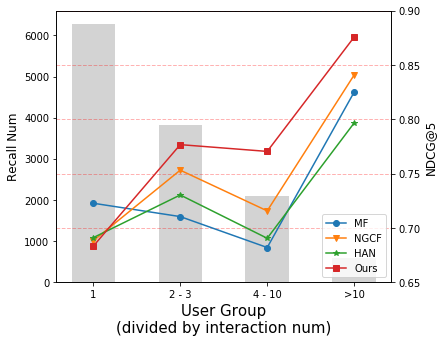

In [57]:

plt.figure(dpi=500)
#plt.figure(figsize=(10,5))
fig, ax1 = plt.subplots(figsize = (6, 5))

width = 0.5
#index = np.arange(len(listLabels))
#tick_label = listLabels
#ax1.bar(index,df_MF_stat['num'],width =width,color='lightsteelblue',label="MF_recall",align="center")
#ax1.bar(index+width,df_HAN_stat['num'],width =width,color='lightskyblue',label="HAN_recall",align="center")
#ax1.bar(index+width+width,df_NGCF_stat['num'],width =width,color='lightseagreen',label="NGCF_recall",align="center")
#ax1.bar(index+width+width+width,df_NHGCF_stat['num'],width =width,color='lightgray',label="NHGCF_recall",align="center")
#ax1.set_ylabel('Recall Num')
#ax1.set_xticks(index+width*1.5, tick_label)
#ax1.legend(loc='upper center')

ax1.bar(listLabels,df_MF_stat['num'],width = width,color='lightsteelblue',label="MF_recall",align="center")
ax1.bar(listLabels,df_NGCF_stat['num'],width = width,color='lightseagreen',label="NGCF_recall",align="center")
ax1.bar(listLabels,df_HAN_stat['num'],width = width,color='lightskyblue',label="HAN_recall",align="center")
ax1.bar(listLabels,df_NHGCF_stat['num'],width = width,color='lightgray',label="Ours_recall",align="center")
ax1.set_ylabel('Recall Num',fontsize=12)
ax1.set_xlabel('User Group\n(divided by interaction num)',fontsize=15)

ax2 = ax1.twinx()
ax2.plot(listLabels,df_MF_stat['ave_ndcg'],label="MF",marker='o')
ax2.plot(listLabels,df_NGCF_stat['ave_ndcg'],label="NGCF",marker='v')
ax2.plot(listLabels,df_HAN_stat['ave_ndcg'],label="HAN",marker='*')
ax2.plot(listLabels,df_NHGCF_stat['ave_ndcg'],label="Ours",marker='s')
#ax2.hlines(0.70, -1, 8, linestyles = "dashed")
#ax2.plot(listLabels,df_NeuMF_stat['ave_ndcg'],label="NeuMF",marker='o')
ax2.set_ylim(.65,.90)
ax2.set_ylabel('NDCG@5',fontsize=12)
ax2.yaxis.grid(color='r', linestyle='--', linewidth=1,alpha=0.3)

#ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

plt.show()

In [176]:
len(dat.train)+len(dat.dev)+len(dat.test)

121566

In [177]:
dat.iNum,dat.uNum

(10669, 18388)

In [163]:
v_,v_hr,v_ndcg

(84812.609375, 0.5400685366163218, 0.7123638791956942)

In [167]:
v_,v_hr,v_ndcg

(308767.65625, 0.5089732199517706, 0.6558992985871475)

In [171]:
v_,v_hr,v_ndcg

(127691.9375, 0.4995303972585354, 0.6507849408939337)

In [11]:
v_,v_hr,v_ndcg

(79835.609375, 0.5477344840715827, 0.6976571486640007)

In [18]:
v_,v_hr,v_ndcg

(85136.234375, 0.539332402589161, 0.7106110944536702)

In [24]:
v_,v_hr,v_ndcg

(100203.734375, 0.5515420738672421, 0.7097259954360793)

In [9]:
v_,v_hr,v_ndcg

(79070.4921875, 0.5571011549689047, 0.7147190219567287)

In [ ]:
data_name = 'ACM'
model_name = 'NHGCF'
hr_record=[]
ndcg_record=[]
for i in range(5):
    #model = MF(para)
    #model = NeuMF(para)
    #model = GCF(para,dat.u2i[0][0])
    #model = HAN(para,dat.mp_graphs)
    model = NHGCF(para,dat.u2i,dat.u2es,dat.i2es)

    #model = torch.nn.DataParallel(model)
    #model.module.weight_init()
    model.weight_init()
    if para['cuda'] == True:
        model = model.cuda()

    if para['continue'] == True:
        model.load_state_dict(torch.load('checkpoint.pt'))

    optim = Adam(model.parameters(), lr=para['lr'],weight_decay=para['weight_decay'])
    BCE_lossfunc = BCEWithLogitsLoss()
    BPR_lossfunc = BPRLoss(model)
    patience = para['patience'] 
    early_stopping = EarlyStopping(patience, verbose=True) 
    dur = []
    loss_record=[]
    
    for epoch in range(para['epoch']):

        if epoch >= 3:
            t0 = time.time()
        loss_log = []
        model.train() # 设置模型为训练模式
        for _id,batch in enumerate(input_train_loader):
            optim.zero_grad()
            if para['cuda']:
                train_loss = BPR_lossfunc(batch[0].cuda(), batch[1].cuda(),batch[2].cuda())
            else:
                train_loss = BPR_lossfunc(batch[0], batch[1],batch[2])
            #print(train_loss)
            train_loss.backward()
            optim.step()
            loss_log.append(train_loss.item())

        val_loss,hr,ndcg = evaluate(dat.eval_dev, dat.input_dev, model, BPR_lossfunc, 5, para['cuda'])

        loss_record.append(np.mean(loss_log))
        

        if epoch > para['epoch_strat']:
            early_stopping(ndcg*(-1), model)   

        if early_stopping.early_stop:
            print("Early stopping")
            break # 结束模型训练   

        if epoch >= 3:
            dur.append(time.time() - t0)

        print("Epoch {:05d} | Time(s) {:.4f} | Train_Loss {:.4f} | Val_Loss {:.4f} | Val_HR@5 {:.4f} | "
                "Val_NDCG@5 {:.4f}". format(epoch, np.mean(dur), np.mean(loss_log),val_loss,
                                                 hr, ndcg))
    model.load_state_dict(torch.load('checkpoint.pt'))
    v_,v_hr,v_ndcg = evaluate(dat.eval_test, dat.input_test, model, BPR_lossfunc, 5, para['cuda'])
    print(v_,v_hr,v_ndcg)
    hr_record.append(v_hr)
    ndcg_record.append(v_ndcg)
    
print(np.mean(hr_record),np.mean(ndcg_record))
df_result = pd.DataFrame()
df_result['hr'] = hr_record
df_result['ndcg']=ndcg_record
df_result.to_csv('result/'+data_name+'_'+model_name+'.csv')

In [8]:
class SemanticAttention(nn.Module):
    def __init__(self, in_size, hidden_size=128):
        super(SemanticAttention, self).__init__()

        self.project = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False)
        )

    def forward(self, z):
        w = self.project(z)
        beta = torch.softmax(w, dim=1)

        return (beta * z).sum(1)

class HANLayer(nn.Module):
    """
    HAN layer.
    Arguments
    ---------
    num_meta_paths : number of homogeneous graphs generated from the metapaths.
    in_size : input feature dimension
    out_size : output feature dimension
    layer_num_heads : number of attention heads
    dropout : Dropout probability
    Inputs
    ------
    g : list[DGLGraph]
        List of graphs
    h : tensor
        Input features
    Outputs
    -------
    tensor
        The output feature
    """
    def __init__(self, num_meta_paths, in_size, out_size, layer_num_heads, dropout):
        super(HANLayer, self).__init__()

        # One GAT layer for each meta path based adjacency matrix
        self.gat_layers = nn.ModuleList()
        for i in range(num_meta_paths):
            self.gat_layers.append(GATConv(in_size, out_size, layer_num_heads,
                                           dropout, dropout, activation=F.elu))
        self.semantic_attention = SemanticAttention(in_size=out_size * layer_num_heads)
        self.num_meta_paths = num_meta_paths

    def forward(self, gs, h):
        semantic_embeddings = []

        for i, g in enumerate(gs):
            semantic_embeddings.append(self.gat_layers[i](g, h).flatten(1))
        semantic_embeddings = torch.stack(semantic_embeddings, dim=1)                  # (N, M, D * K)

        return self.semantic_attention(semantic_embeddings)                            # (N, D * K)

class HAN(nn.Module):
    def __init__(self,config, gs):
        super(HAN, self).__init__()
        self.gs = gs
        self.usecuda = config['cuda']
        self.dropout = config['dropout']
        self.num_heads = config['num_heads']
        self.num_meta_paths = len(gs)
        self.userNum = config['num_users']
        self.itemNum = config['num_items']
        self.uEmbd = nn.Embedding(config['num_users'],config['embed_dim'])
        self.iEmbd = nn.Embedding(config['num_items'],config['embed_dim'])
        self.in_size = config['embed_dim']
        self.hidden_size = config['hidden_dim']
        #self.h = torch.cat((self.uEmbd,self.iEmbd),dim=0)
        self.layers = nn.ModuleList()
        self.layers.append(HANLayer(self.num_meta_paths, self.in_size, self.hidden_size, self.num_heads[0], self.dropout))
        for l in range(1, len(self.num_heads)):
            self.layers.append(HANLayer(self.num_meta_paths, self.hidden_size * self.num_heads[l-1],
                                        self.hidden_size,  self.num_heads[l],  self.dropout))
        #self.predict = nn.Linear(hidden_size * num_heads[-1], 1)
    
    def weight_init(self):
        wts = [
            self.uEmbd.weight,
            self.iEmbd.weight,
            self.layers[0].gat_layers[0].fc.weight,
            self.layers[0].gat_layers[1].fc.weight,
            self.layers[0].gat_layers[2].fc.weight,
           # self.layers[0].gat_layers[3].fc.weight,
            #self.layers[0].gat_layers[4].fc.weight,
            #self.layers[0].gat_layers[5].fc.weight,
            self.layers[0].semantic_attention.project[0].weight,
            self.layers[0].semantic_attention.project[2].weight
            #self.layers[1].gat_layers[0].fc.weight,
            #self.layers[1].gat_layers[1].fc.weight,
            #self.layers[1].gat_layers[2].fc.weight,
            #self.layers[1].semantic_attention.project[0].weight,
            #self.layers[1].semantic_attention.project[2].weight
            #self.layers[2].gat_layers[0].fc.weight,
            #self.layers[2].gat_layers[1].fc.weight,
            #self.layers[2].gat_layers[2].fc.weight,
            #self.layers[2].semantic_attention.project[0].weight,
            #self.layers[2].semantic_attention.project[2].weight
        ]
        
        for wt in wts:
            nn.init.xavier_normal_(wt, gain=1)  
    
    def getFeatureMat(self):
        uidx = torch.LongTensor([i for i in range(self.userNum)])
        iidx = torch.LongTensor([i for i in range(self.itemNum)])
        if self.usecuda  == True:
            uidx = uidx.cuda()
            iidx = iidx.cuda()
        #print(type(uidx))
        userEmbd = self.uEmbd(uidx)
        itemEmbd = self.iEmbd(iidx)

        features = torch.cat([userEmbd,itemEmbd],dim=0)
        return features
    
    def forward(self, userIdx,itemIdx):
        itemIdx = itemIdx + self.userNum
        features = self.getFeatureMat()
        #finalEmbd = features.clone()
        for gnn in self.layers:
            features = gnn(self.gs, features)
            features = normalize(features, 2, 1) # L2 Norm
          
        userEmbd = features[userIdx]
        itemEmbd = features[itemIdx]    
        #print(userEmbd.size()) 
        add  = torch.mul(userEmbd,itemEmbd)
        logits = torch.sum(add,dim=1)
        
        return logits

In [40]:
class RelationAttention(nn.Module):
    def __init__(self, in_size, hidden_size=32):
        super(RelationAttention, self).__init__()
        self.project = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False))

    def forward(self, z):
        w = self.project(z)
        beta = torch.softmax(w, dim=1)
        return (beta * z).sum(1)
    
    
class Message_Passing(Module):
    def __init__(self,inF,outF,useCuda):
        super(Message_Passing,self).__init__()
        self.inF = inF
        self.outF = outF
        self.useCuda = useCuda
        self.Transform = torch.nn.Linear(in_features=inF,out_features=outF)
        self.InterAct = torch.nn.Linear(in_features=inF,out_features=outF)

    def forward(self, L, L_hat,features):
        if self.useCuda:
            L=L.cuda()
            L_hat = L_hat.cuda()
        inter_part1 = torch.sparse.mm(L_hat,self.Transform(features))     
        inter_part2 = torch.sparse.mm(L,self.InterAct(torch.mul(features,features)))
        return inter_part1+inter_part2
    
    
class Message_Storage(Module):
    def __init__(self,useCuda):
        super(Message_Storage,self).__init__()
        self.useCuda = useCuda

    def forward(self, L_hat,features):
        if self.useCuda:
            L_hat = L_hat.cuda()
        return torch.sparse.mm(L_hat,features) 
    
    
class NHGCFLayer(Module):
    def __init__(self,inF,outF,useCuda,self_tag_u2es, self_tag_i2es):
        super(NHGCFLayer,self).__init__()
        self.inF = inF
        self.outF = outF
        self.useCuda = useCuda

        self.u2i_Cell = Message_Passing(inF,outF,useCuda)
        
        self.u2e_Cells = torch.nn.ModuleList()
        for i in self_tag_u2es:
            if i==True:
                self.u2e_Cells.append(Message_Passing(inF,outF,useCuda))
            else:
                self.u2e_Cells.append(torch.nn.ModuleList([Message_Passing(inF,outF,useCuda),Message_Storage(useCuda)]))
                
        self.i2e_Cells = torch.nn.ModuleList()
        for i in self_tag_i2es:
            if i==True:
                self.i2e_Cells.append(Message_Passing(inF,outF,useCuda))
            else:
                self.i2e_Cells.append(torch.nn.ModuleList([Message_Passing(inF,outF,useCuda),Message_Storage(useCuda)]))
         
        self.u_relation_attention = RelationAttention(in_size=self.inF)
        self.i_relation_attention = RelationAttention(in_size=self.inF)
        #self.relation_attention = RelationAttention(in_size=self.inF)
        
    def forward(self, u2i_pack, u2e_pack, i2e_pack, u_feature, i_feature, u2e_features, i2e_features):
        u_embeddings = []
        i_embeddings = []
        u2e_embeddings =[]
        i2e_embeddings =[]
        u_num = u2i_pack[1][0]
        #i_num = u2i_pack[2][1]
        
        for ((L_upper,L_upper_hat,L_down_hat),self_tag),u2e_feature,u2e_Cell in zip(u2e_pack,u2e_features,self.u2e_Cells):
            if self_tag is True:
                # self interact
                u_embeddings.append(u2e_Cell(L_upper,L_upper_hat,u_feature))
            else:
                u2e_embeddings.append(u2e_Cell[1](L_down_hat,torch.cat([u_feature,u2e_feature],dim=0)))
                u_embeddings.append(u2e_Cell[0](L_upper,L_upper_hat,torch.cat([u_feature,u2e_feature],dim=0)))
            
            
        for ((L_upper,L_upper_hat,L_down_hat),self_tag),i2e_feature,i2e_Cell in zip(i2e_pack,i2e_features,self.i2e_Cells):
            if self_tag is True:
                # self interact
                i_embeddings.append(i2e_Cell(L_upper,L_upper_hat,i_feature))
            else:
                i2e_embeddings.append(i2e_Cell[1](L_down_hat,torch.cat([i_feature,i2e_feature],dim=0)))
                i_embeddings.append(i2e_Cell[0](L_upper,L_upper_hat,torch.cat([i_feature,i2e_feature],dim=0)))
                
        temp = self.u2i_Cell(u2i_pack[0][0],u2i_pack[0][1],torch.cat([u_feature,i_feature],dim=0))
        i_embeddings.append(temp[u_num:]) 
        u_embeddings.append(temp[:u_num])
        
        i_embeddings = torch.stack(i_embeddings, dim=1)
        u_embeddings = torch.stack(u_embeddings, dim=1)
        return torch.sum(u_embeddings, dim=1),torch.sum(i_embeddings, dim=1),u2e_embeddings,i2e_embeddings
        #return self.relation_attention(u_embeddings),self.relation_attention(i_embeddings),u2e_embeddings,i2e_embeddings
    
    

class NHGCF_noattn(Module):
    def __init__(self,config,u2i,u2es,i2es):
        """
        u2es[x][0]: laplacian
        u2es[x][1]: node num
        u2es[x][2]: self intercat tag
        """
        super(NHGCF_noattn,self).__init__()
        self.useCuda = config['cuda']
        
        self.userNum = u2i[1][0]
        self.itemNum = u2i[1][1]
        
        self.uEmbd = nn.Embedding(self.userNum,config['embed_dim'])
        self.iEmbd = nn.Embedding(self.itemNum,config['embed_dim'])
        self.u2i_pack = (u2i[0],[self.userNum,self.itemNum])
        
        
        self.u2eEmbds=torch.nn.ModuleList()
        self.L_u2es = []
        self.self_tag_u2es = []
        self.u2eNums =[]
        for u2e in u2es:
            self.L_u2es.append(u2e[0])
            self.u2eNums.append(u2e[1])
            if u2e[2]==False:
                self.u2eEmbds.append(nn.Embedding(u2e[1],config['embed_dim']))
            else:
                self.u2eEmbds.append(None)
            self.self_tag_u2es.append(u2e[2])
        self.u2e_pack = zip(self.L_u2es,self.self_tag_u2es)
            
        self.i2eEmbds=torch.nn.ModuleList()
        self.L_i2es = []
        self.self_tag_i2es = []
        self.i2eNums =[]
        for i2e in i2es:
            self.L_i2es.append(i2e[0])
            self.i2eNums.append(i2e[1])
            if i2e[2]==False:
                self.i2eEmbds.append(nn.Embedding(i2e[1],config['embed_dim']))
            else:
                self.i2eEmbds.append(None)
            self.self_tag_i2es.append(i2e[2])
        self.i2e_pack = zip(self.L_i2es,self.self_tag_i2es)    
    
        self.layers = config['layers']
        self.NHGCFLayers = torch.nn.ModuleList()
        self.leakyRelu = nn.LeakyReLU()

        for From,To in zip(self.layers[:-1],self.layers[1:]):
            self.NHGCFLayers.append(NHGCFLayer(From, To, self.useCuda, self.self_tag_u2es, self.self_tag_i2es))  
    # 参数初始化
    def weight_init(self):
        wts= [self.uEmbd.weight,
            self.iEmbd.weight,
            self.NHGCFLayers[0].u2i_Cell.Transform.weight,
            self.NHGCFLayers[0].u2i_Cell.InterAct.weight,
            self.NHGCFLayers[0].u2e_Cells[0].Transform.weight,
            self.NHGCFLayers[0].u2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[0].i2e_Cells[0].Transform.weight,
            self.NHGCFLayers[0].i2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[0].u_relation_attention.project[0].weight,
            self.NHGCFLayers[0].u_relation_attention.project[2].weight,
            self.NHGCFLayers[0].i_relation_attention.project[0].weight,
            self.NHGCFLayers[0].i_relation_attention.project[2].weight,
              
            self.NHGCFLayers[1].u2i_Cell.Transform.weight,
            self.NHGCFLayers[1].u2i_Cell.InterAct.weight,
            self.NHGCFLayers[1].u2e_Cells[0].Transform.weight,
            self.NHGCFLayers[1].u2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[1].i2e_Cells[0].Transform.weight,
            self.NHGCFLayers[1].i2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[1].u_relation_attention.project[0].weight,
            self.NHGCFLayers[1].u_relation_attention.project[2].weight,
            self.NHGCFLayers[1].i_relation_attention.project[0].weight,
            self.NHGCFLayers[1].i_relation_attention.project[2].weight,
              
            self.NHGCFLayers[2].u2i_Cell.Transform.weight,
            self.NHGCFLayers[2].u2i_Cell.InterAct.weight,
            self.NHGCFLayers[2].u2e_Cells[0].Transform.weight,
            self.NHGCFLayers[2].u2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[2].i2e_Cells[0].Transform.weight,
            self.NHGCFLayers[2].i2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[2].u_relation_attention.project[0].weight,
            self.NHGCFLayers[2].u_relation_attention.project[2].weight,
            self.NHGCFLayers[2].i_relation_attention.project[0].weight,
            self.NHGCFLayers[2].i_relation_attention.project[2].weight
              
            #self.NHGCFLayers[3].u2i_Cell.Transform.weight,
            #self.NHGCFLayers[3].u2i_Cell.InterAct.weight,
            #self.NHGCFLayers[3].u2e_Cells[0].Transform.weight,
            #self.NHGCFLayers[3].u2e_Cells[0].InterAct.weight,
            #self.NHGCFLayers[3].i2e_Cells[0].Transform.weight,
            #self.NHGCFLayers[3].i2e_Cells[0].InterAct.weight,
            #self.NHGCFLayers[3].u_relation_attention.project[0].weight,
            #self.NHGCFLayers[3].u_relation_attention.project[2].weight,
            #self.NHGCFLayers[3].i_relation_attention.project[0].weight,
            #self.NHGCFLayers[3].i_relation_attention.project[2].weight,
              ]
        wts2 = [
            #self.u2eEmbds[1].weight,
            #self.u2eEmbds[2].weight,
            #self.i2eEmbds[1].weight
        ]
        for wt in wts:
            nn.init.xavier_normal_(wt, gain=1) 
        for wt in wts2:
            nn.init.constant_(wt, 0.0)
            
    
    def getFeatureMat(self,num,embd):
        idx = torch.LongTensor([i for i in range(num)])
        if self.useCuda == True:
            idx = idx.cuda()
        fullEmbd = embd(idx)
        return fullEmbd

    def forward(self,userIdx,itemIdx):

        #itemIdx = itemIdx + self.userNum
        u_feature = self.getFeatureMat(self.userNum,self.uEmbd)
        i_feature = self.getFeatureMat(self.itemNum,self.iEmbd)
        
        u2e_features = []
        for num,embd in zip(self.u2eNums,self.u2eEmbds):
            if embd is not None:
                u2e_features.append(self.getFeatureMat(num,embd))
            else:
                # self interact
                u2e_features.append(None)
            
        i2e_features = []
        for num,embd in zip(self.i2eNums,self.i2eEmbds):
            if embd is not None:
                u2e_features.append(self.getFeatureMat(num,embd))
            else:
                # self interact
                u2e_features.append(None)
        
        u_finalEmbd = u_feature.clone()
        i_finalEmbd = i_feature.clone()
        for gnn in self.NHGCFLayers:
            u_feature, i_feature, u2e_features, i2e_features = gnn(self.u2i_pack, self.u2e_pack, self.i2e_pack, 
                                                                   u_feature, i_feature, u2e_features, i2e_features)
            u_feature = self.leakyRelu(u_feature)
            i_feature = self.leakyRelu(i_feature)
            u_feature = normalize(u_feature, 2, 1) # L2 Norm
            i_feature = normalize(i_feature, 2, 1) # L2 Norm
            #u2e_features = [self.leakyRelu(f) if (f is not None) else None for f in u2e_features]
            #i2e_features = [self.leakyRelu(f) if (f is not None) else None for f in i2e_features]
            u_finalEmbd = torch.cat([u_finalEmbd,u_feature.clone()],dim=1)
            i_finalEmbd = torch.cat([i_finalEmbd,i_feature.clone()],dim=1)

        userEmbd = u_finalEmbd[userIdx]
        itemEmbd = i_finalEmbd[itemIdx]

        add  = torch.mul(userEmbd,itemEmbd)
        logits = torch.sum(add,dim=1)

        return logits

In [7]:
class Message_Passing(Module):
    def __init__(self,inF,outF,num_list,useCuda):
        super(Message_Passing,self).__init__()
        self.inF = inF
        self.outF = outF
        self.useCuda = useCuda
        
        self.uNum = num_list[0]
        self.iNum = num_list[1]

        
        self.Transform = torch.nn.Linear(in_features=inF,out_features=outF)
        self.InterAct = torch.nn.Linear(in_features=inF,out_features=outF)

    def forward(self, L, L_hat,features):
        if self.useCuda:
            L=L.cuda()
            L_hat = L_hat.cuda()
        inter_part1 = torch.sparse.mm(L_hat,self.Transform(features))     
        inter_part2 = torch.sparse.mm(L,self.InterAct(torch.mul(features,features)))
        full =  inter_part1+inter_part2
        u_feature = full[:self.uNum]
        i_feature = full[self.uNum:]
        return u_feature,i_feature

class NHGCF_norelation(Module):

    def __init__(self,config,L,L_hat,num_list):

        super(NHGCF_norelation,self).__init__()
        self.useCuda = config['cuda']
        self.uNum = num_list[0]
        self.iNum = num_list[1]
        
        self.uEmbd = nn.Embedding(self.uNum,config['embed_dim'])
        self.iEmbd = nn.Embedding(self.iNum,config['embed_dim'])
        
        self.layers = config['layers']
        self.GNNlayers = torch.nn.ModuleList()
        self.L = L # sparse format
        self.L_hat = L_hat
        self.leakyRelu = nn.LeakyReLU()
        
        for From,To in zip(self.layers[:-1],self.layers[1:]):
            self.GNNlayers.append(Message_Passing(From,To,num_list,self.useCuda))
    
     # 参数初始化
    def weight_init(self):
        wts= [self.uEmbd.weight,
              self.iEmbd.weight,     
              self.GNNlayers[0].Transform.weight,
              self.GNNlayers[0].InterAct.weight,
              self.GNNlayers[1].Transform.weight,
              self.GNNlayers[1].InterAct.weight,
              self.GNNlayers[2].Transform.weight,
              self.GNNlayers[2].InterAct.weight
              #self.transForm1.weight,
              #self.transForm2.weight,
              #self.transForm3.weight,
              ]
        for wt in wts:
            nn.init.xavier_normal_(wt, gain=1)      


    def getFeatureMat(self,num,embd):
        idx = torch.LongTensor([i for i in range(num)])
        if self.useCuda == True:
            idx = idx.cuda()
        fullEmbd = embd(idx)
        return fullEmbd

    def forward(self,userIdx,itemIdx):
        
        u_feature = self.getFeatureMat(self.uNum,self.uEmbd)
        i_feature = self.getFeatureMat(self.iNum,self.iEmbd)
        
        u_finalEmbd = u_feature.clone()
        i_finalEmbd = i_feature.clone()
        for gnn in self.GNNlayers:
            u_feature,i_feature = gnn(self.L,self.L_hat,torch.cat([u_feature,i_feature]))
            u_feature = normalize(self.leakyRelu(u_feature), 2, 1)
            i_feature = normalize(self.leakyRelu(i_feature), 2, 1)
            
            u_finalEmbd = torch.cat([u_finalEmbd,u_feature.clone()],dim=1)
            i_finalEmbd = torch.cat([i_finalEmbd,i_feature.clone()],dim=1)
            
        userEmbd = u_finalEmbd[userIdx]
        itemEmbd = i_finalEmbd[itemIdx]

        add  = torch.mul(userEmbd,itemEmbd)
        logits = torch.sum(add,dim=1)

        return logits

In [ ]:
class RelationAttention(nn.Module):
    def __init__(self, in_size, hidden_size):
        super(RelationAttention, self).__init__()
        self.project = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False))

    def forward(self, z):
        w = self.project(z)
        beta = torch.softmax(w, dim=1)
        return (beta * z).sum(1)
    
    
class Message_Passing(Module):
    def __init__(self,inF,outF,useCuda):
        super(Message_Passing,self).__init__()
        self.inF = inF
        self.outF = outF
        self.useCuda = useCuda
        self.Transform = torch.nn.Linear(in_features=inF,out_features=outF)
        self.InterAct = torch.nn.Linear(in_features=inF,out_features=outF)

    def forward(self, L, L_hat,features):
        if self.useCuda:
            L=L.cuda()
            L_hat = L_hat.cuda()
        inter_part1 = torch.sparse.mm(L_hat,self.Transform(features))     
        inter_part2 = torch.sparse.mm(L,self.InterAct(torch.mul(features,features)))
        return inter_part1+inter_part2
    
    
class Message_Storage(Module):
    def __init__(self,useCuda):
        super(Message_Storage,self).__init__()
        self.useCuda = useCuda

    def forward(self, L_hat,features):
        if self.useCuda:
            L_hat = L_hat.cuda()
        return torch.sparse.mm(L_hat,features) 
    
    
class NHGCFLayer(Module):
    def __init__(self,inF,outF,proj_dim,useCuda,self_tag_u2es, self_tag_i2es):
        super(NHGCFLayer,self).__init__()
        self.inF = inF
        self.outF = outF
        self.useCuda = useCuda

        self.u2i_Cell = Message_Passing(inF,outF,useCuda)
        
        self.u2e_Cells = torch.nn.ModuleList()
        for i in self_tag_u2es:
            if i==True:
                self.u2e_Cells.append(Message_Passing(inF,outF,useCuda))
            else:
                self.u2e_Cells.append(torch.nn.ModuleList([Message_Passing(inF,outF,useCuda),Message_Storage(useCuda)]))
                
        self.i2e_Cells = torch.nn.ModuleList()
        for i in self_tag_i2es:
            if i==True:
                self.i2e_Cells.append(Message_Passing(inF,outF,useCuda))
            else:
                self.i2e_Cells.append(torch.nn.ModuleList([Message_Passing(inF,outF,useCuda),Message_Storage(useCuda)]))
         
        self.u_relation_attention = RelationAttention(in_size=self.inF,hidden_size=proj_dim)
        self.i_relation_attention = RelationAttention(in_size=self.inF,hidden_size=proj_dim)
        #self.relation_attention = RelationAttention(in_size=self.inF)
        
    def forward(self, u2i_pack, u2e_pack, i2e_pack, u_feature, i_feature, u2e_features, i2e_features):
        u_embeddings = []
        i_embeddings = []
        u2e_embeddings =[]
        i2e_embeddings =[]
        u_num = u2i_pack[1][0]
        #i_num = u2i_pack[2][1]
        
        for ((L_upper,L_upper_hat,L_down_hat),self_tag),u2e_feature,u2e_Cell in zip(u2e_pack,u2e_features,self.u2e_Cells):
            if self_tag is True:
                # self interact
                u_embeddings.append(u2e_Cell(L_upper,L_upper_hat,u_feature))
            else:
                u2e_embeddings.append(u2e_Cell[1](L_down_hat,torch.cat([u_feature,u2e_feature],dim=0)))
                u_embeddings.append(u2e_Cell[0](L_upper,L_upper_hat,torch.cat([u_feature,u2e_feature],dim=0)))
            
            
        for ((L_upper,L_upper_hat,L_down_hat),self_tag),i2e_feature,i2e_Cell in zip(i2e_pack,i2e_features,self.i2e_Cells):
            if self_tag is True:
                # self interact
                i_embeddings.append(i2e_Cell(L_upper,L_upper_hat,i_feature))
            else:
                i2e_embeddings.append(i2e_Cell[1](L_down_hat,torch.cat([i_feature,i2e_feature],dim=0)))
                i_embeddings.append(i2e_Cell[0](L_upper,L_upper_hat,torch.cat([i_feature,i2e_feature],dim=0)))
                
        temp = self.u2i_Cell(u2i_pack[0][0],u2i_pack[0][1],torch.cat([u_feature,i_feature],dim=0))
        i_embeddings.append(temp[u_num:]) 
        u_embeddings.append(temp[:u_num])
        
        i_embeddings = torch.stack(i_embeddings, dim=1)
        u_embeddings = torch.stack(u_embeddings, dim=1)
        return self.u_relation_attention(u_embeddings),self.i_relation_attention(i_embeddings),u2e_embeddings,i2e_embeddings
        #return self.relation_attention(u_embeddings),self.relation_attention(i_embeddings),u2e_embeddings,i2e_embeddings
    
    

class NHGCF_share_proj(Module):
    def __init__(self,config,u2i,u2es,i2es):
        """
        u2es[x][0]: laplacian
        u2es[x][1]: node num
        u2es[x][2]: self intercat tag
        """
        super(NHGCF,self).__init__()
        self.useCuda = config['cuda']
        
        self.userNum = u2i[1][0]
        self.itemNum = u2i[1][1]
        self.proj_dim = config['proj_dim']
        
        self.uEmbd = nn.Embedding(self.userNum,config['embed_dim'])
        self.iEmbd = nn.Embedding(self.itemNum,config['embed_dim'])
        self.u2i_pack = (u2i[0],[self.userNum,self.itemNum])
        
        self.u2eEmbds=torch.nn.ModuleList()
        self.L_u2es = []
        self.self_tag_u2es = []
        self.u2eNums =[]
        for u2e in u2es:
            self.L_u2es.append(u2e[0])
            self.u2eNums.append(u2e[1])
            if u2e[2]==False:
                self.u2eEmbds.append(nn.Embedding(u2e[1],config['embed_dim']))
            else:
                self.u2eEmbds.append(None)
            self.self_tag_u2es.append(u2e[2])
        self.u2e_pack = zip(self.L_u2es,self.self_tag_u2es)
            
        self.i2eEmbds=torch.nn.ModuleList()
        self.L_i2es = []
        self.self_tag_i2es = []
        self.i2eNums =[]
        for i2e in i2es:
            self.L_i2es.append(i2e[0])
            self.i2eNums.append(i2e[1])
            if i2e[2]==False:
                self.i2eEmbds.append(nn.Embedding(i2e[1],config['embed_dim']))
            else:
                self.i2eEmbds.append(None)
            self.self_tag_i2es.append(i2e[2])
        self.i2e_pack = zip(self.L_i2es,self.self_tag_i2es)    
    
        self.layers = config['layers']
        self.NHGCFLayers = torch.nn.ModuleList()
        self.leakyRelu = nn.LeakyReLU()

        for From,To in zip(self.layers[:-1],self.layers[1:]):
            self.NHGCFLayers.append(NHGCFLayer(From, To,self.proj_dim, self.useCuda, self.self_tag_u2es, self.self_tag_i2es))  
    # 参数初始化
    def weight_init(self):
        wts= [self.uEmbd.weight,
            self.iEmbd.weight,
            self.NHGCFLayers[0].u2i_Cell.Transform.weight,
            self.NHGCFLayers[0].u2i_Cell.InterAct.weight,
            self.NHGCFLayers[0].u2e_Cells[0].Transform.weight,
            self.NHGCFLayers[0].u2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[0].i2e_Cells[0].Transform.weight,
            self.NHGCFLayers[0].i2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[0].u_relation_attention.project[0].weight,
            self.NHGCFLayers[0].u_relation_attention.project[2].weight,
            self.NHGCFLayers[0].i_relation_attention.project[0].weight,
            self.NHGCFLayers[0].i_relation_attention.project[2].weight,
              
            self.NHGCFLayers[1].u2i_Cell.Transform.weight,
            self.NHGCFLayers[1].u2i_Cell.InterAct.weight,
            self.NHGCFLayers[1].u2e_Cells[0].Transform.weight,
            self.NHGCFLayers[1].u2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[1].i2e_Cells[0].Transform.weight,
            self.NHGCFLayers[1].i2e_Cells[0].InterAct.weight,
            self.NHGCFLayers[1].u_relation_attention.project[0].weight,
            self.NHGCFLayers[1].u_relation_attention.project[2].weight,
            self.NHGCFLayers[1].i_relation_attention.project[0].weight,
            self.NHGCFLayers[1].i_relation_attention.project[2].weight,
              
            #self.NHGCFLayers[2].u2i_Cell.Transform.weight,
            #self.NHGCFLayers[2].u2i_Cell.InterAct.weight,
            #self.NHGCFLayers[2].u2e_Cells[0].Transform.weight,
            #self.NHGCFLayers[2].u2e_Cells[0].InterAct.weight,
            #self.NHGCFLayers[2].i2e_Cells[0].Transform.weight,
            #self.NHGCFLayers[2].i2e_Cells[0].InterAct.weight,
            #self.NHGCFLayers[2].u_relation_attention.project[0].weight,
            #self.NHGCFLayers[2].u_relation_attention.project[2].weight,
            #self.NHGCFLayers[2].i_relation_attention.project[0].weight,
            #self.NHGCFLayers[2].i_relation_attention.project[2].weight
              
            #self.NHGCFLayers[3].u2i_Cell.Transform.weight,
            #self.NHGCFLayers[3].u2i_Cell.InterAct.weight,
            #self.NHGCFLayers[3].u2e_Cells[0].Transform.weight,
            #self.NHGCFLayers[3].u2e_Cells[0].InterAct.weight,
            #self.NHGCFLayers[3].i2e_Cells[0].Transform.weight,
            #self.NHGCFLayers[3].i2e_Cells[0].InterAct.weight,
            #self.NHGCFLayers[3].u_relation_attention.project[0].weight,
            #self.NHGCFLayers[3].u_relation_attention.project[2].weight,
            #self.NHGCFLayers[3].i_relation_attention.project[0].weight,
            #self.NHGCFLayers[3].i_relation_attention.project[2].weight,
              ]
        wts2 = [
            #self.u2eEmbds[1].weight,
            #self.u2eEmbds[2].weight,
            #self.i2eEmbds[1].weight
        ]
        for wt in wts:
            nn.init.xavier_normal_(wt, gain=1) 
        for wt in wts2:
            nn.init.constant_(wt, 0.0)
            
    
    def getFeatureMat(self,num,embd):
        idx = torch.LongTensor([i for i in range(num)])
        if self.useCuda == True:
            idx = idx.cuda()
        fullEmbd = embd(idx)
        return fullEmbd

    def forward(self,userIdx,itemIdx):

        #itemIdx = itemIdx + self.userNum
        u_feature = self.getFeatureMat(self.userNum,self.uEmbd)
        i_feature = self.getFeatureMat(self.itemNum,self.iEmbd)
        
        u2e_features = []
        for num,embd in zip(self.u2eNums,self.u2eEmbds):
            if embd is not None:
                u2e_features.append(self.getFeatureMat(num,embd))
            else:
                # self interact
                u2e_features.append(None)
            
        i2e_features = []
        for num,embd in zip(self.i2eNums,self.i2eEmbds):
            if embd is not None:
                u2e_features.append(self.getFeatureMat(num,embd))
            else:
                # self interact
                u2e_features.append(None)
        
        u_finalEmbd = u_feature.clone()
        i_finalEmbd = i_feature.clone()
        for gnn in self.NHGCFLayers:
            u_feature, i_feature, u2e_features, i2e_features = gnn(self.u2i_pack, self.u2e_pack, self.i2e_pack, 
                                                                   u_feature, i_feature, u2e_features, i2e_features)
            u_feature = self.leakyRelu(u_feature)
            i_feature = self.leakyRelu(i_feature)
            u_feature = normalize(u_feature, 2, 1) # L2 Norm
            i_feature = normalize(i_feature, 2, 1) # L2 Norm
            #u2e_features = [self.leakyRelu(f) if (f is not None) else None for f in u2e_features]
            #i2e_features = [self.leakyRelu(f) if (f is not None) else None for f in i2e_features]
            u_finalEmbd = torch.cat([u_finalEmbd,u_feature.clone()],dim=1)
            i_finalEmbd = torch.cat([i_finalEmbd,i_feature.clone()],dim=1)

        userEmbd = u_finalEmbd[userIdx]
        itemEmbd = i_finalEmbd[itemIdx]

        add  = torch.mul(userEmbd,itemEmbd)
        logits = torch.sum(add,dim=1)

        return logits